# Problem and Data Explanation
**The Objective is to predict the employees who are going to leave the company.**  
**we have really less information\features that describes the employees so this might be challenging.  
Churn is the target variable(Yes/No) a binary  outcome.**  

In [1]:
##Importing the necessary dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes = True)
%matplotlib inline

## setting some plotting defaults
plt.rcParams['font.size'] = 24
plt.rcParams['patch.edgecolor']  = 'k'

plt.style.use('fivethirtyeight')

In [2]:
## Loading the dataset
pd.options.display.max_columns = 250

df = pd.read_csv('churn_data.csv')
df.head(8)
#df.shape



,satisfaction,evaluation,number_of_projects,average_montly_hours,time_spend_company,work_accident,churn,promotion,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low


In [3]:
## lets gather some information about the database
df.info()
'''
We have 2 float32 features
we have 6 integer columns
we have 2 columns whose dtype is object
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction            14999 non-null float64
evaluation              14999 non-null float64
number_of_projects      14999 non-null int64
average_montly_hours    14999 non-null int64
time_spend_company      14999 non-null int64
work_accident           14999 non-null int64
churn                   14999 non-null int64
promotion               14999 non-null int64
department              14999 non-null object
salary                  14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


'\nWe have 2 float32 features\nwe have 6 integer columns\nwe have 2 columns whose dtype is object\n'

In [4]:
## description of the dataset
df.describe().T
'''
When I looked aruond  satisfaction and evaluation they appears to be important 
In case of satisfaction,it has got high variability and also it seems that it is normalized.
same for evaluation.
Nothing abnormal with average_monthly_hours because there are employees who are deployed on more projects so they 
had to work more.
'''

'\nWhen I looked aruond  satisfaction and evaluation they appears to be important \nIn case of satisfaction,it has got high variability and also it seems that it is normalized.\nsame for evaluation.\nNothing abnormal with average_monthly_hours because there are employees who are deployed on more projects so they \nhad to work more.\n'

The Unique Values in each columns
number_of_projects        6
average_montly_hours    215
time_spend_company        8
work_accident             2
churn                     2
promotion                 2
dtype: int64


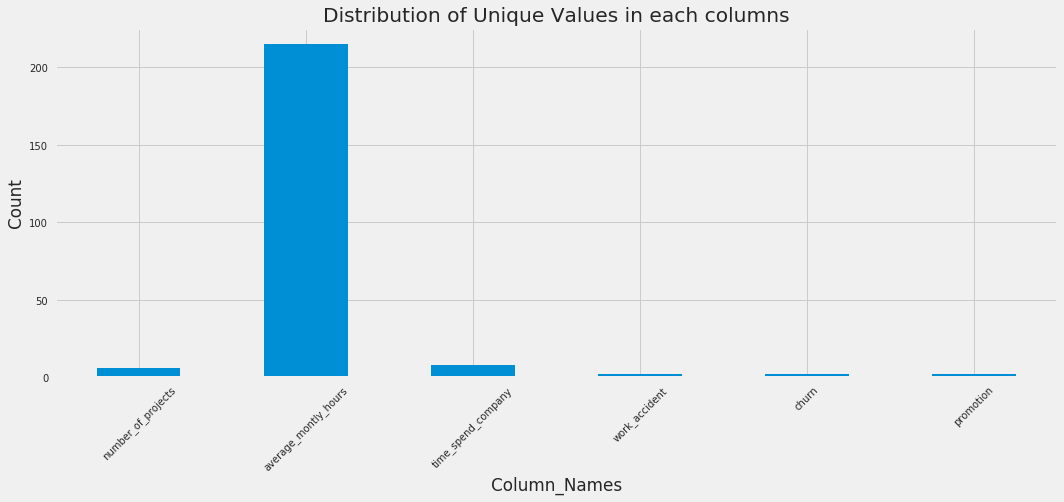

In [5]:
##Lets check the distribution of unique values in integer type columns.
# Counting the number of unique values and showing with bar chart
df.select_dtypes([np.int64]).apply(pd.Series.nunique,axis = 0).plot(kind = 'bar',figsize = (16,6))
plt.xticks(rotation = 45)
plt.xlabel('Column_Names')
plt.ylabel('Count')
plt.title("Distribution of Unique Values in each columns")

print("The Unique Values in each columns")
print(df.select_dtypes([np.int64]).apply(pd.Series.nunique,axis = 0))

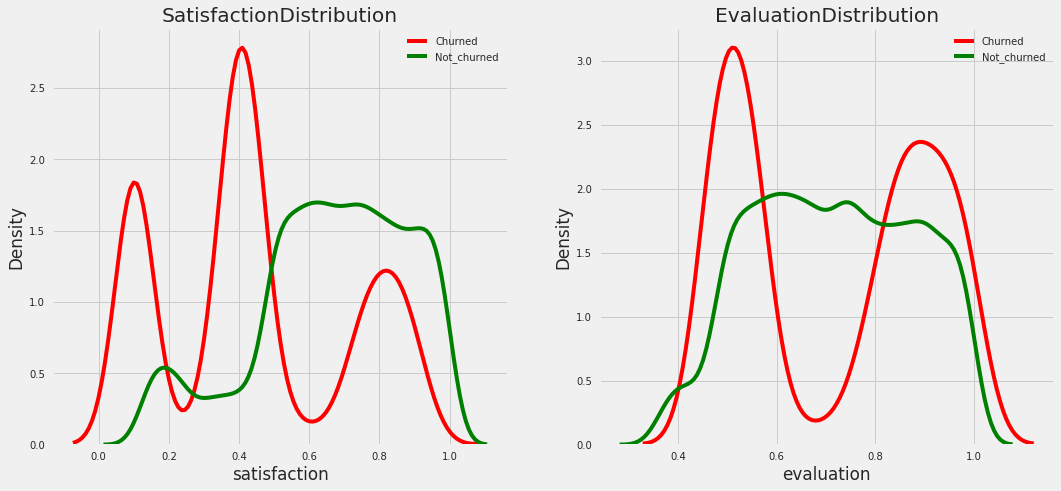

In [6]:
##Inspecting for Float32 dtype 
# we can make a quick distriution plot to show the distribution of all float columns
from collections import OrderedDict
colors = OrderedDict({1:'red',0:'green'})
churn_mapping = OrderedDict({1:'Churned',0:'Not_churned'})
plt.figure(figsize = (16,3))
##Iterating through the float columns
for i,col in enumerate(df.select_dtypes([np.float64])):
    ax = plt.subplot(1,2,i+1)
    
    for chrn,color in colors.items():
        sns.kdeplot(df.loc[df['churn'] == chrn,col].dropna(),ax = ax,color = color,
                   label = churn_mapping[chrn])
    plt.title(f'{col.capitalize()}Distribution')
    plt.xlabel(f'{col}')
    plt.ylabel('Density')
plt.subplots_adjust(top = 2)

Thus it is clear from the kdeplot that  
1) Those who were satisfied did not churned.  
2) those who were over evaluated and under evaluated left the company as(0.4 to 0.6) and (0.8 to 1.0)  

In [7]:
##Inspecting the Object columns
df.select_dtypes(['object']).head(8)

##its about department and salary
print('There are',df['salary'].nunique(),'classes in salary')
print(df['department'].nunique(),'is the number of distinct classes in department')

There are 3 classes in salary
10 is the number of distinct classes in department


Percentage of People who stayed with the company is 0.761917461164 %
Percentage of People who left the company is 0.238082538836 %


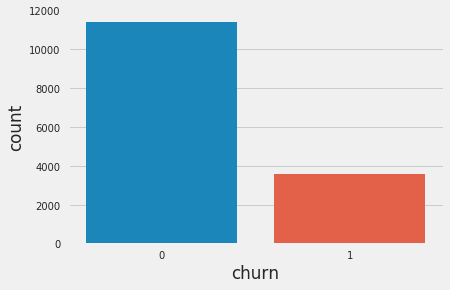

In [8]:
##Lets inspect the Label of the Dataset
'''
We can get the idea of how imbalanced the problem is,by looking at the distribution of labels.
'''
label_df = df['churn'].value_counts()
print('Percentage of People who stayed with the company is',label_df[0]/df.shape[0],'%')
print('Percentage of People who left the company is',label_df[1]/df.shape[0],'%')
sns.countplot(df['churn'])

Problems related to this type can naver be balanced because only few people are having different characters as compared to others.

In [9]:
##Lets check for missing variables
missing_val = [df.isnull().sum()>0]
missing_val

##Thus this dataset dosen't contain any missing values.

[satisfaction            False
 evaluation              False
 number_of_projects      False
 average_montly_hours    False
 time_spend_company      False
 work_accident           False
 churn                   False
 promotion               False
 department              False
 salary                  False
 dtype: bool]

**Plot two categorical variables**


variation of scatter plot where size of bubble depends on the percentage of a given y_value represented by x_values.

In [10]:
def plot_categoricals(x, y, data, annotate = True):
    """Plot counts of two categoricals.
    Size is raw count for each grouping.
    Percentages are for a given value of y."""
    
    # Raw counts 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # Calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Rename the column and reset the index
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    # Scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'orange',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # Annotate the plot with text
        for i, row in counts.iterrows():
            # Put text with appropriate offsets
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), 
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy',
                         s = f"{round(row['percent'], 1)}%")
        
    # Set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # Markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'red',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # Legend and formatting
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # Adjust axes limits
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}"); plt.ylabel(f"{y}"); plt.title(f"{y} vs {x}");

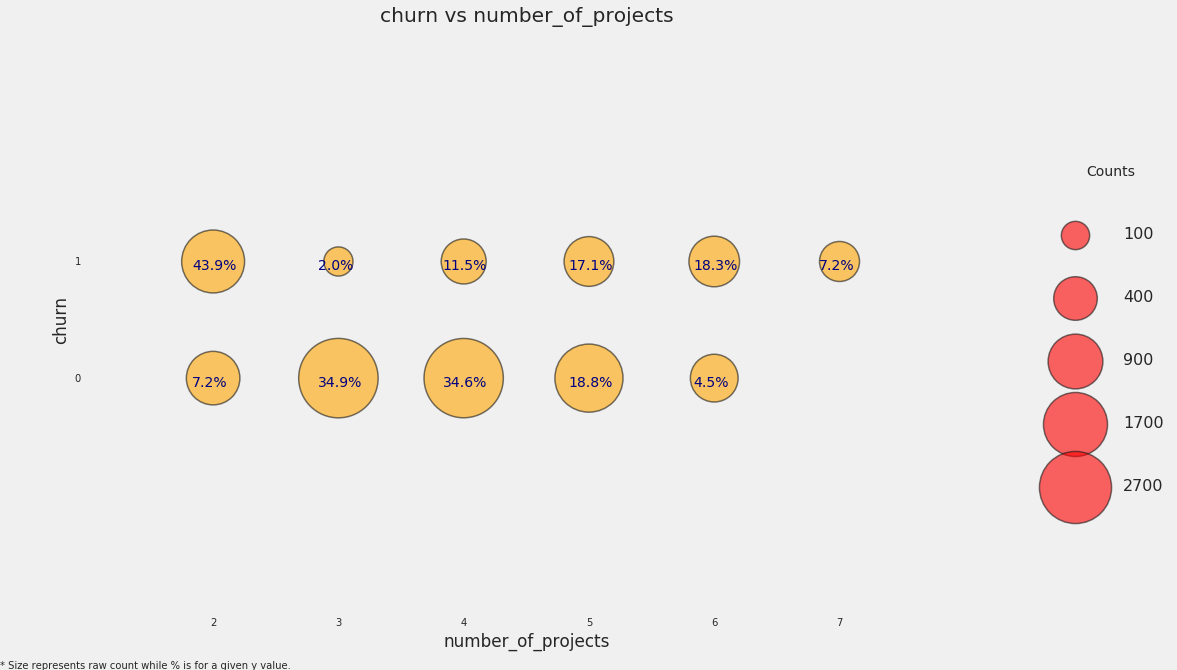

In [11]:
plot_categoricals('number_of_projects','churn',data = df,annotate = True)

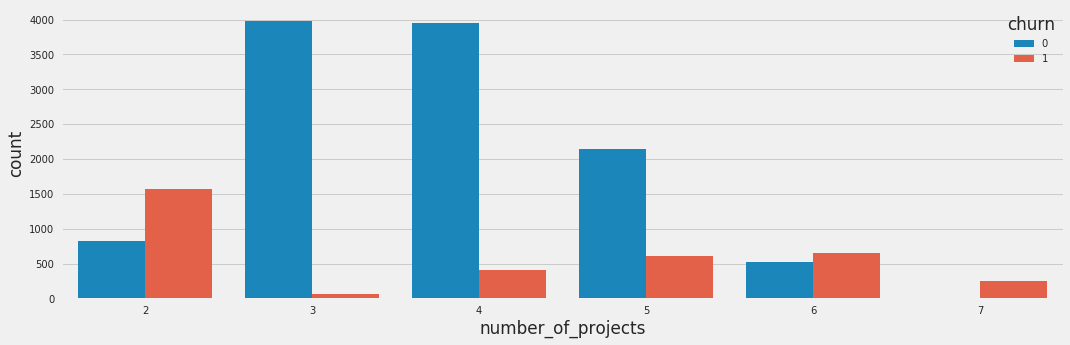

In [12]:
#I found bar plot more informing
plt.figure(figsize = (16,5))
sns.countplot(df['number_of_projects'],hue = df['churn'])

**Thus it can be concluded that if people has less no of projects then they will churn out and if people will be having more number of projects then also they will churn**

As if number of projects are 2 then employees churned because of less work.(or may be sitting on Bench) or may be boring projects.
And if the number is greater then 6 and 7 then employees are going to leave the company because of worl overload.

Feature creation

1)Work Underload-->represented as 0

2)balanced Work-->represented as 1

3)Work Overload-->represented as 2

,satisfaction,evaluation,number_of_projects,average_montly_hours,time_spend_company,work_accident,churn,promotion,department,salary,work_load
0,0.38,0.53,2,157,3,0,1,0,sales,low,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,1
2,0.11,0.88,7,272,4,0,1,0,sales,medium,2
3,0.72,0.87,5,223,5,0,1,0,sales,low,1
4,0.37,0.52,2,159,3,0,1,0,sales,low,0


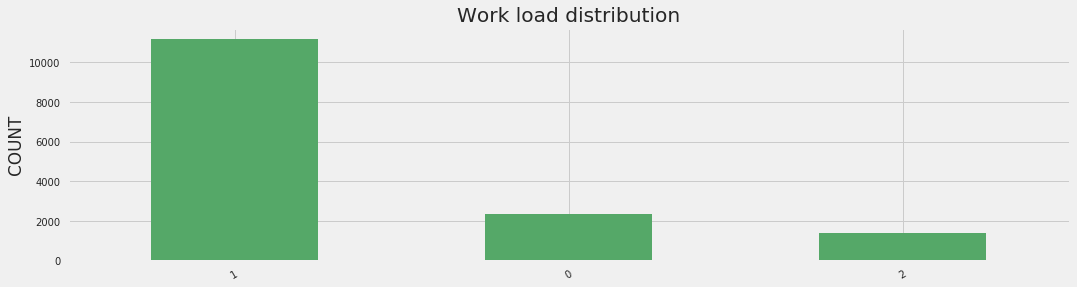

In [13]:
##Creating new feature work_load
df['work_load'] = df['number_of_projects'].map({2:0,3:1,4
                                               :1,5:1,6:2,
                                               7:2})
df['work_load'].value_counts().plot(kind = 'bar',color = 'g',figsize = (16,4))
plt.xticks(rotation = 30)
plt.title('Work load distribution')
plt.ylabel('COUNT')
df.head()

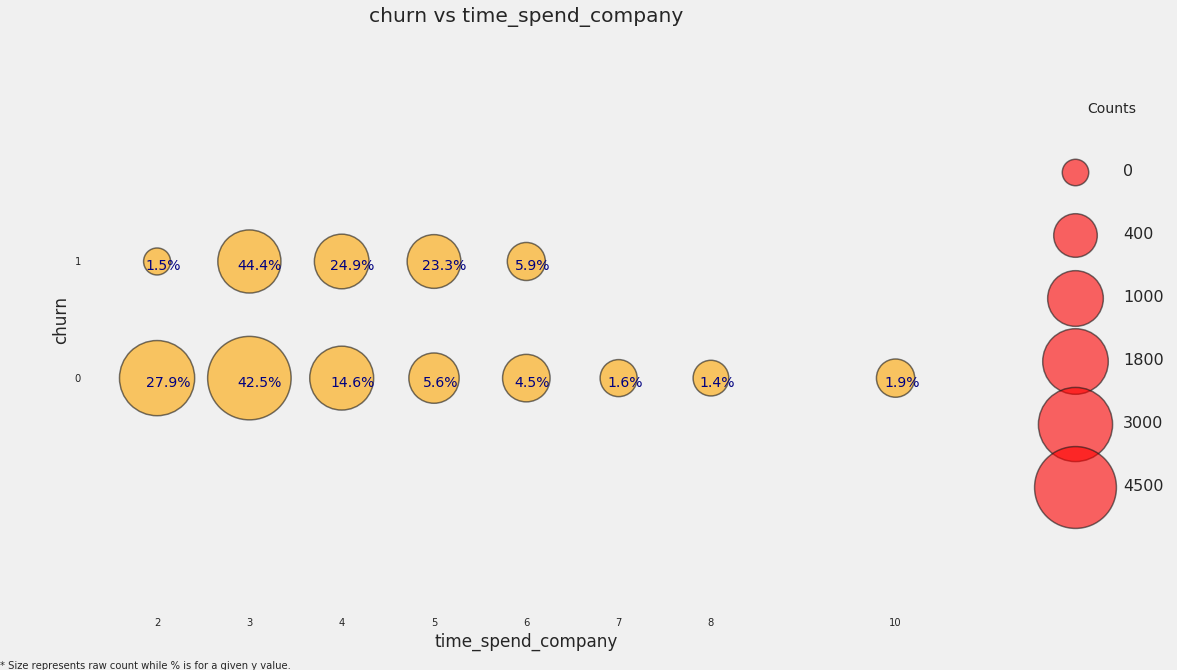

In [14]:
##lets inspect TIME SPEND COMPANY
plot_categoricals('time_spend_company','churn',data = df,annotate  =True)

Not many things are clear but as expected new comers and old employees are not going to churn out. The reasons are well understood.

Outcome;---

People having work experience of more then 6 years are not going to churn and new comers having 2 years of experience. Time b/w 3-6 is  more likely to see changes.Thus it will help in feature creation.

1 for changes are seen in the company if employee falling in the range of (3 -6).  
0 for no changes are to be seen in the company 

In [15]:
##Creating new feature based on time_spend_company
df['if_changes'] = df['time_spend_company'].map({2:0,7:0,8:0,10:0,
                                             3:1,4:1,5:1,6:1})
df['if_changes'] = df['if_changes'].astype(int)
df.head()

,satisfaction,evaluation,number_of_projects,average_montly_hours,time_spend_company,work_accident,churn,promotion,department,salary,work_load,if_changes
0,0.38,0.53,2,157,3,0,1,0,sales,low,0,1
1,0.80,0.86,5,262,6,0,1,0,sales,medium,1,1
2,0.11,0.88,7,272,4,0,1,0,sales,medium,2,1
3,0.72,0.87,5,223,5,0,1,0,sales,low,1,1
4,0.37,0.52,2,159,3,0,1,0,sales,low,0,1


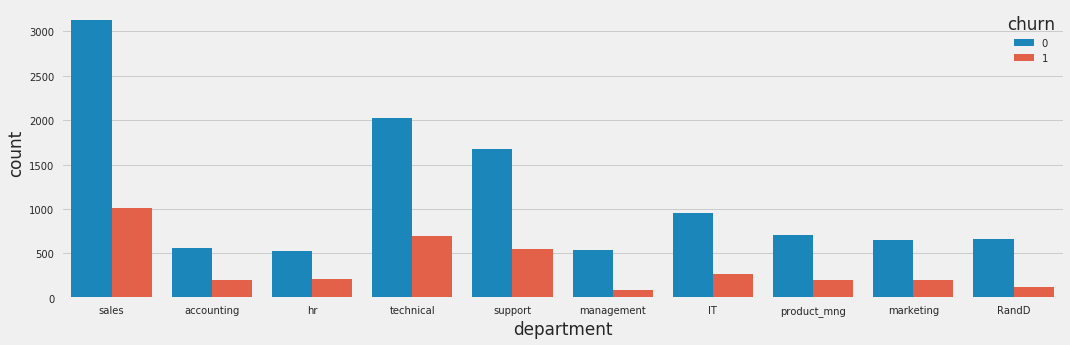

In [16]:
##Inspecting with department
plt.figure(figsize = (16,5))
sns.countplot(df['department'],hue = df['churn'])

/home/ankit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


Text(0.5,1,'% of people left department wise')

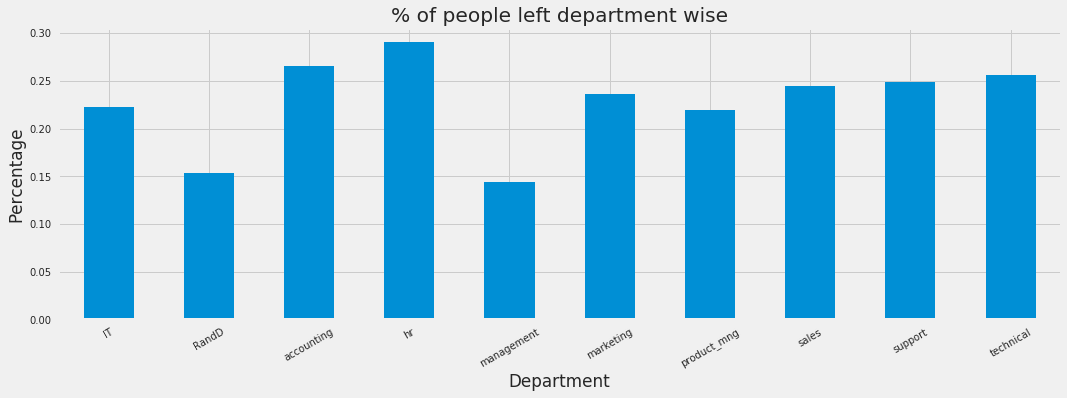

In [17]:
## we are not intersested in numbers but percentage.
counts_val = df['department'].value_counts()
gp_churn = df.groupby('department')['churn']
gp_churn = gp_churn.agg({'department':'sum'})
combi = pd.DataFrame({'count':counts_val,'sum_by_churn':gp_churn['department']})
per_churn_by_group = combi['sum_by_churn']/combi['count']
per_churn_by_group.plot(kind = 'bar',figsize = (16,5))
plt.xlabel('Department')
plt.xticks(rotation = 30)
plt.ylabel('Percentage')
plt.title('% of people left department wise')

Thus the most vulnearable departments to churn are   
accounting,Hr,technical  
And the least vulnearable to changes are  
managment and it shuold be.  
We can think of a hypothesis that people in management department are paid higher.  

Feature creation   
is_dept_vul  
0 for vulnearable  
1 for normal  
2 for safe

,satisfaction,evaluation,number_of_projects,average_montly_hours,time_spend_company,work_accident,churn,promotion,department,salary,work_load,if_changes,dept_vul
0,0.38,0.53,2,157,3,0,1,0,sales,low,0,1,1
1,0.80,0.86,5,262,6,0,1,0,sales,medium,1,1,1
2,0.11,0.88,7,272,4,0,1,0,sales,medium,2,1,1
3,0.72,0.87,5,223,5,0,1,0,sales,low,1,1,1
4,0.37,0.52,2,159,3,0,1,0,sales,low,0,1,1


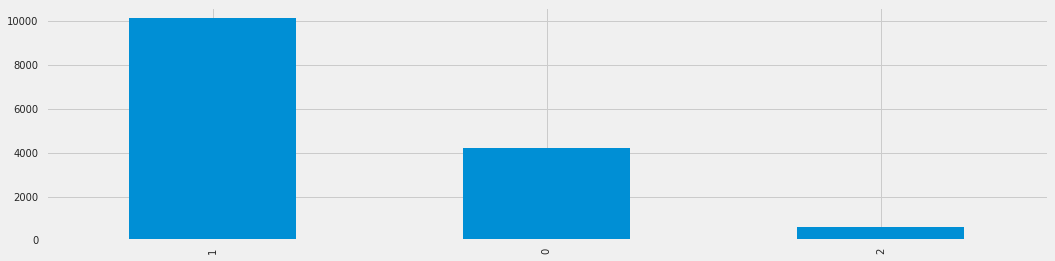

In [18]:
df['dept_vul'] = df['department'].map({'hr':0,'accounting':0,'technical':0,
                                         'management':2,'IT':1,'RandD':1,'marketing':1,'sales':1,
                                         'support':1,'product_mng':1})
df['dept_vul'].value_counts().plot(kind = 'bar',figsize = (16,4))
df.head()

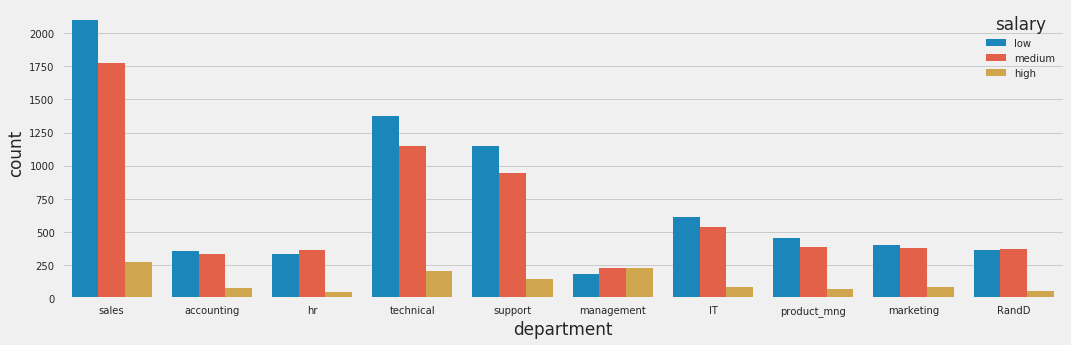

In [19]:
##Lets inspect salary with department
plt.figure(figsize = (16,5))
sns.countplot( df['department'],hue = df['salary'])
##thus our hypothesis was correct people in managment are paid nicely.
##in accounting section more people had poor salary. so its highly vulnearable.

In [20]:
##Lets inspect salary department and churn together with the help of groupby 
dept_sal_chrn = df.groupby(['department','salary'])['churn'].agg({'department':'sum'})
dept_sal_chrn

/home/ankit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


department
department  salary            
IT          high             4
            low            172
            medium          97
RandD       high             4
            low             55
            medium          62
accounting  high             5
            low             99
            medium         100
hr          high             6
            low             92
            medium         117
management  high             1
            low             59
            medium          31
marketing   high             9
            low            126
            medium          68
product_mng high             6
            low            105
            medium          87
sales       high            14
            low            697
            medium         303
support     high             8
            low            389
            medium         158
technical   high            25
            low            378
            medium         294

Text(0,0.5,'Count')

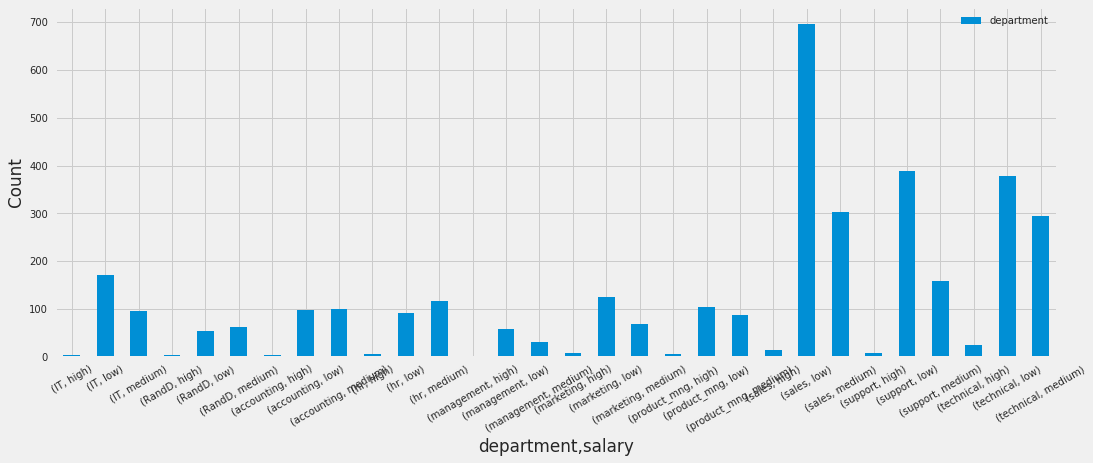

In [21]:
##Plotting the distribution
dept_sal_chrn.plot(kind = 'bar',figsize = (16,6))
plt.xticks(rotation = 30)
plt.ylabel('Count')

Text(0.5,1,'People who churned in different departments satalry wise')

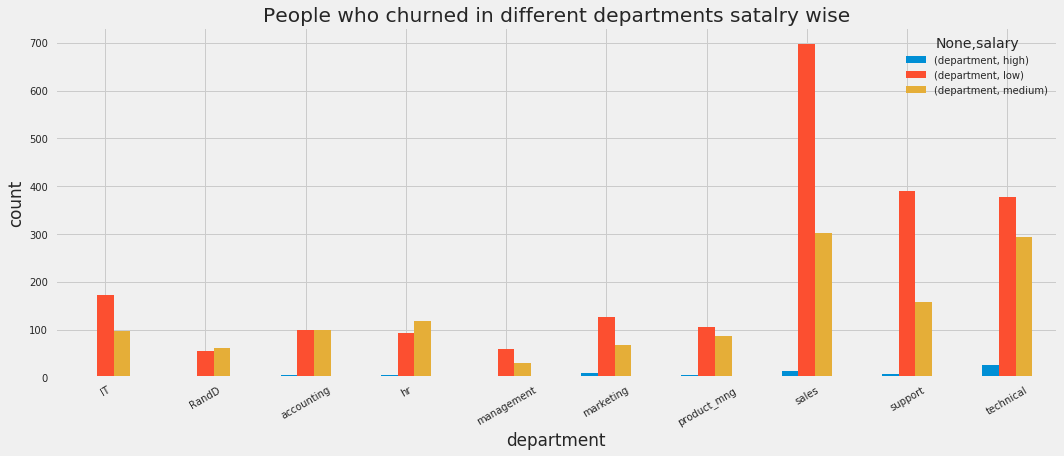

In [22]:
##Better plot
dept_sal_chrn.unstack().plot(kind = 'bar',figsize = (16,6))
plt.xticks(rotation = 30)
plt.ylabel('count')
plt.title('People who churned in different departments satalry wise')

##It could be an important feature

Text(0.5,1,'Churn count VS (department,salary,if_changes)')

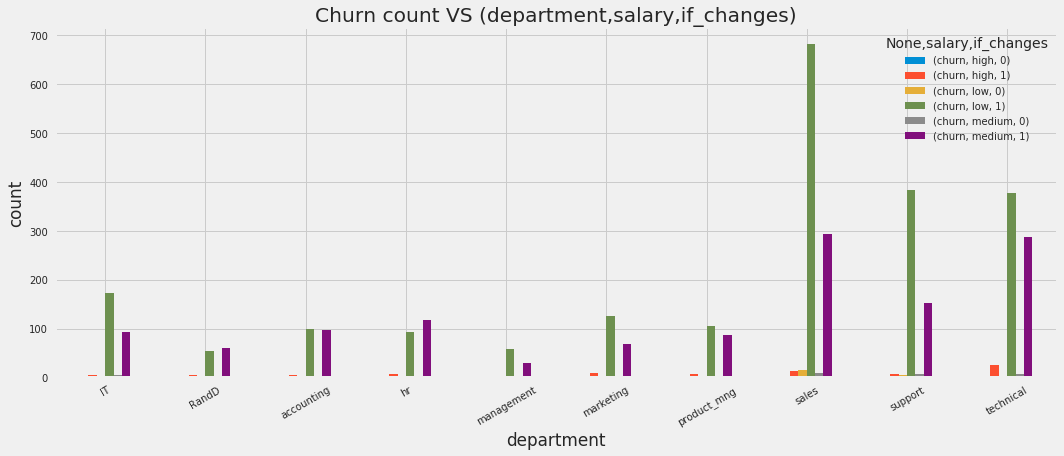

In [23]:
##cann't we do the above operation adding experience.
gp_yr_churn = df.pivot_table(index = 'department',columns = ['salary','if_changes'],values = ['churn'],aggfunc = 'sum')
gp_yr_churn.plot(kind = 'bar',figsize = (16,6))
plt.xticks(rotation = 30)
plt.ylabel('count')
plt.title("Churn count VS (department,salary,if_changes)")
#This will even construct an important feature.

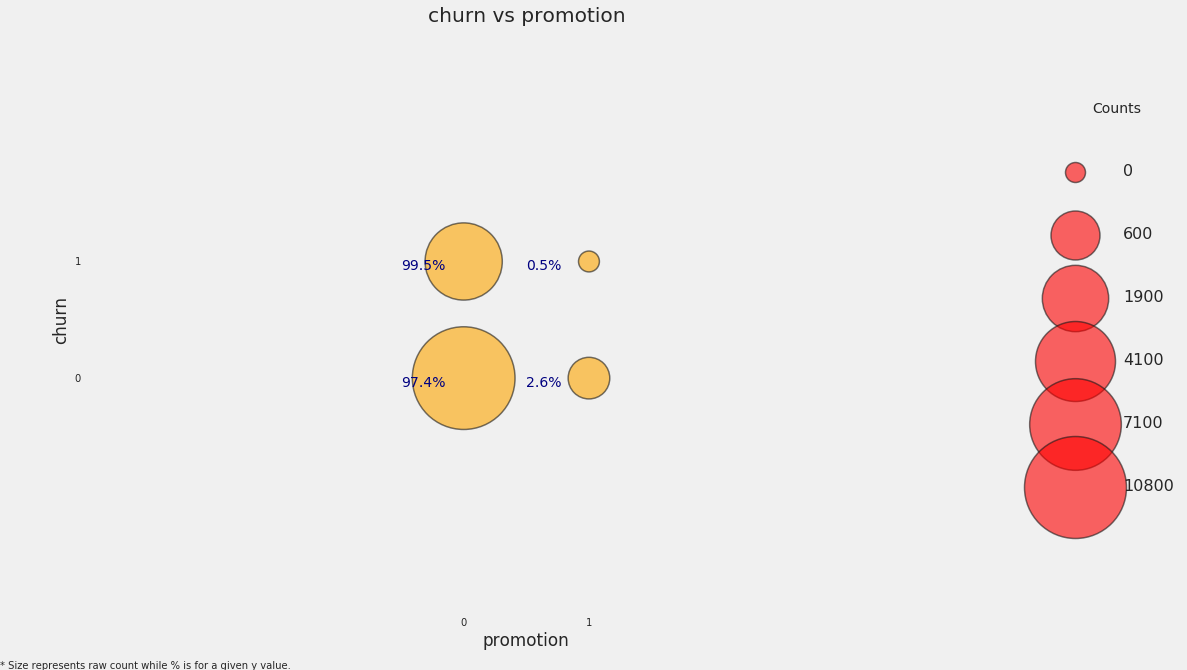

In [24]:
##Lets see promotion with target variable
plot_categoricals('promotion','churn',data = df,annotate = True)
##Nothing is clear much but we can say if promoted then less chances of leaving the company.
##Lets try promotion ,time_spend-company by churn

/home/ankit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


Text(0.5,1000,"Those who were promoted didn't left")

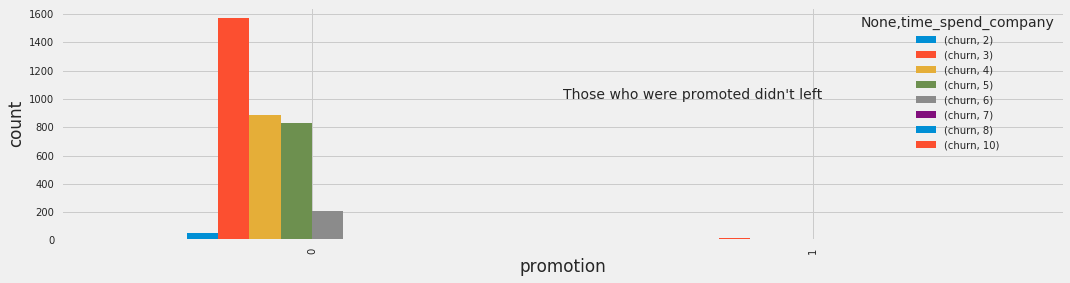

In [25]:
churn_promotion = df.groupby(['promotion','time_spend_company'])['churn'].agg({'churn':'sum'})
churn_promotion.unstack().plot(kind = 'bar',figsize = (16,4))
plt.ylabel('count')
plt.text(0.5,1000,'Those who were promoted didn\'t left')

Due to no promotion people with 3 years of experience left the company and this is common.  
Lets examine which department saw less promotion.  

/home/ankit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


Text(0.5,1,'% of people promoted department wise')

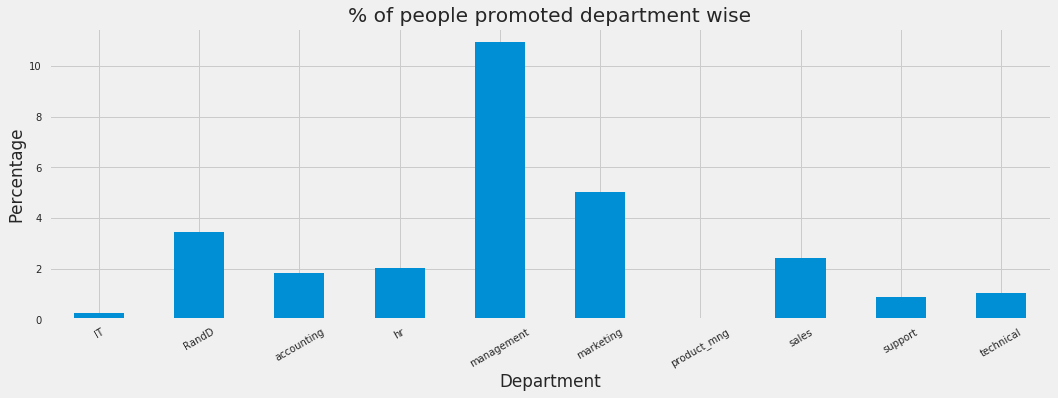

In [26]:
## we are interested in percentage
promo_dept = df.groupby('department')['promotion'].agg({'promotion':'sum'})
comb = pd.DataFrame({'count':counts_val,'promo_dep':promo_dept['promotion']})
per_promotion_dept = comb['promo_dep']/comb['count']*100
per_promotion_dept.plot(kind = 'bar',figsize = (16,5))
plt.xlabel('Department')
plt.xticks(rotation = 30)
plt.ylabel('Percentage')
plt.title('% of people promoted department wise')

More then 10% people were promoted in managment section and they had nice wages thus they didn't left unlike other sections.  
product_manager and IT seen least promotion.  
well IT people are not parmanent in some companies they are hired on contract(Not SURE)  

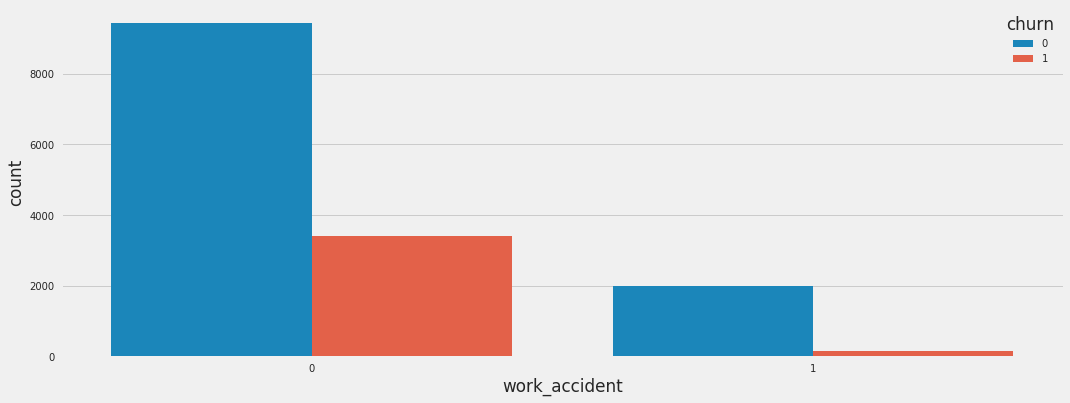

In [27]:
## Lets see what work accident tells us.
plt.figure(figsize = (16,6))
sns.countplot(df['work_accident'],hue = df['churn'])
##Nothing important

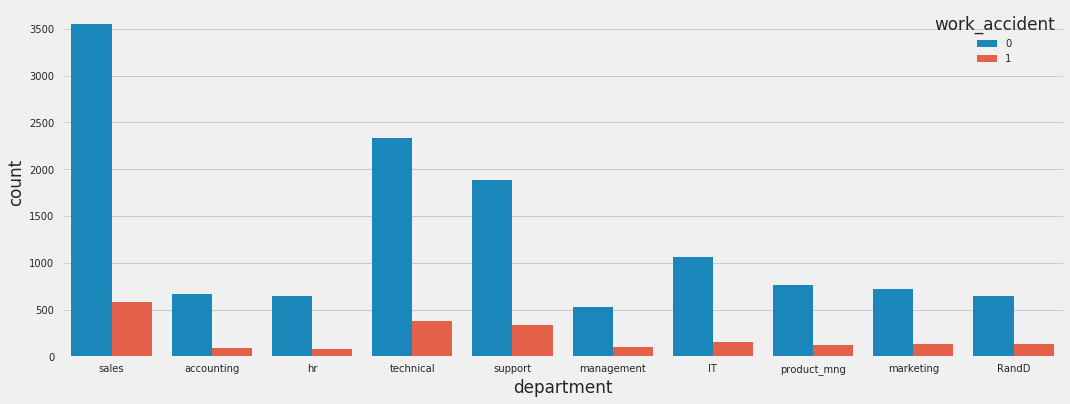

In [28]:
plt.figure(figsize = (16,6))
sns.countplot(df['department'],hue = df['work_accident'])

/home/ankit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


Text(0.5,1,'churned department wise w.r.t work accident')

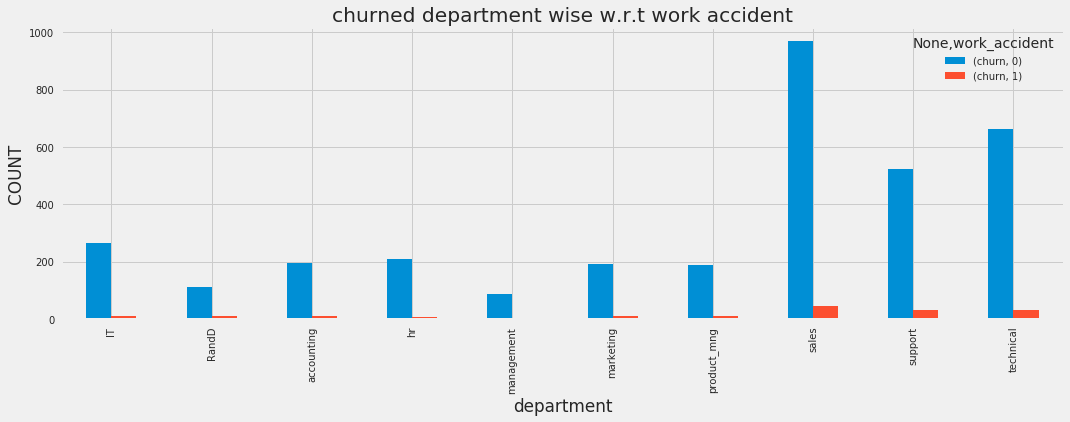

In [29]:
##Lets understand department wise churn who met with accident
gp_accident = df.groupby(['department','work_accident'])['churn'].agg({'churn':'sum'})
gp_accident.unstack().plot(kind = 'bar',figsize = (16,5))
plt.ylabel('COUNT')
plt.title('churned department wise w.r.t work accident')

##one funny thing is people working in managment are safest.(I don't know why)

Text(0.7,0.9,'area of churning')

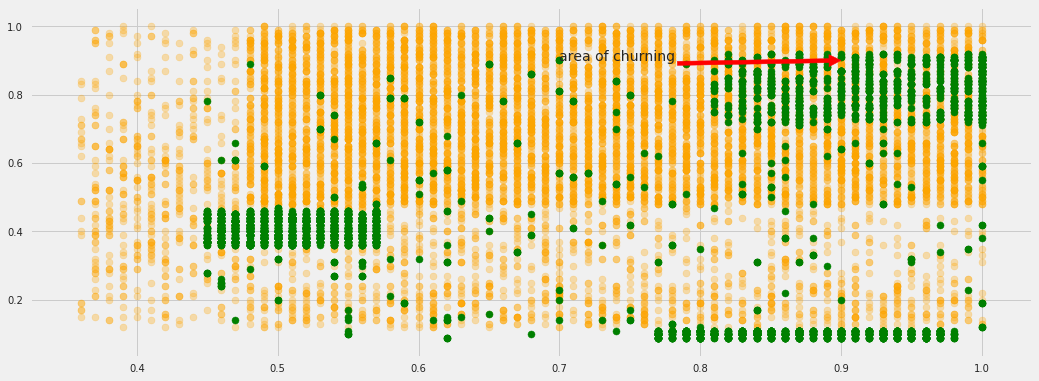

In [30]:
##Time to inspect Evaluation and satisfaction
plt.figure(figsize = (16,6))
plt.scatter(x = df.loc[(df['churn'] == 0),'evaluation'],y = df.loc[(df['churn'] == 0),'satisfaction'],color = 'orange',alpha = 0.3)
plt.scatter(x = df.loc[(df['churn'] == 1),'evaluation'],y = df.loc[(df['churn'] == 1),'satisfaction'],color = 'green')
plt.annotate('area of churning',xy = (0.9,0.9),xytext = (0.7,0.9),arrowprops = {'color':'red'})

There is very interseting patttern to note   
the employees who were good left the company(The upper right region) arrow showing one region.  
there are bascially three regoins in the plot which is clearly visible.  
Lets create feature for that.  

In [31]:
##Feature creation remains

**Lets Inspect Satisfaction and Evaluation level department wise**  
It may give some important insight for feature engineering

/home/ankit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


             evaluation
department             
IT             0.716830
RandD          0.712122
accounting     0.717718
hr             0.708850
management     0.724000
marketing      0.715886
product_mng    0.714756
sales          0.709717
support        0.723109
technical      0.721099
0.7161017401159978


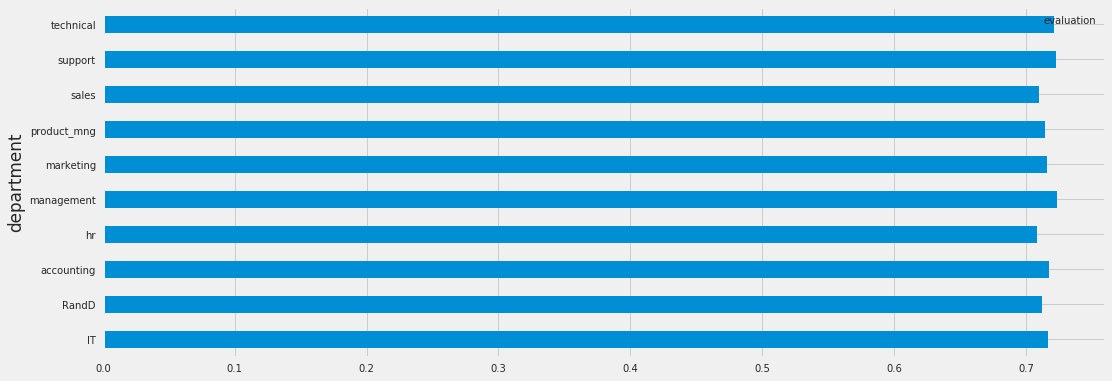

In [32]:
eval_group = df.groupby('department')['evaluation'].agg({'evaluation':'mean'})
eval_group.plot(kind = 'barh',figsize = (16,6))
print(eval_group)
print(df['evaluation'].mean())

##All departments have roughly same mean

/home/ankit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


             evaluation
department             
IT             0.618142
RandD          0.619822
accounting     0.582151
hr             0.598809
management     0.621349
marketing      0.618601
product_mng    0.619634
sales          0.614447
support        0.618300
technical      0.607897
0.6128335222348166


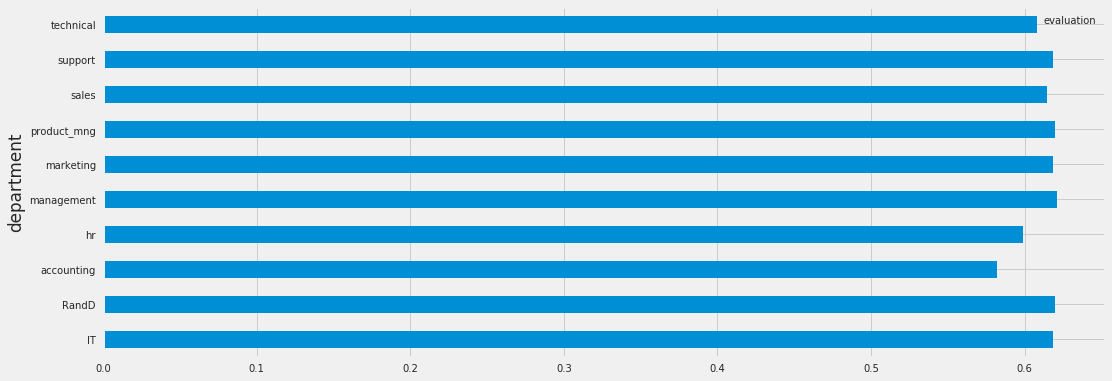

In [33]:
satis_group = df.groupby('department')['satisfaction'].agg({'evaluation':'mean'})
satis_group.plot(kind = 'barh',figsize = (16,6))
print(satis_group)
print(df['satisfaction'].mean())


##Similar effcet

In [34]:
##Satisfaction and evaluation level based on salary
sal_group = df.groupby('salary')[['satisfaction','evaluation']].agg({'satisfaction':'mean','evaluation':'mean'})
sal_group

##This is also similar but highly paid people are highly satisfied.

,satisfaction,evaluation
salary,,
high,0.637470,0.704325
low,0.600753,0.717017
medium,0.621817,0.717322


**Lets Turn our attention to average monthly hours**   
This features describes of number of hours an employee is working in the company.  

This will help us to create many features.  
1) Number of hours given to per project.  
2) department wise average monthly hours.  
3) finnaly we'll do binning for this features and aggregate with number of employees in that group.  

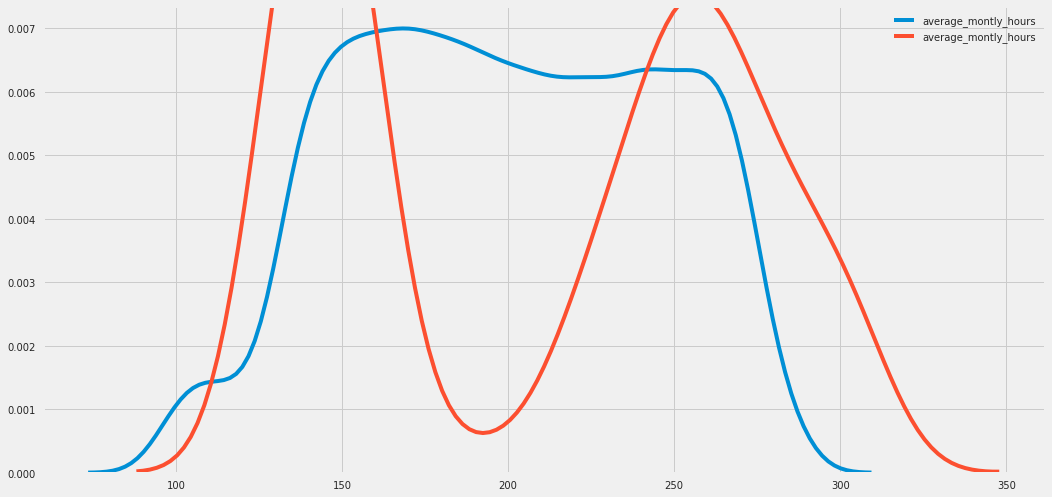

In [35]:
##Distribution of average_monthly_hours
plt.figure(figsize = (16,8))
sns.kdeplot(df.loc[df['churn'] == 0,'average_montly_hours'].dropna())   #Blue
sns.kdeplot(df.loc[df['churn'] == 1,'average_montly_hours'].dropna())   #Red

**One thing is clear is out of this plot  
If an employee is having more number of hours monthly he/she is definitely going to leave.  
Similarly due to lack of projects or work_hours employee may churn out.  
The favourable Blue plot tells us about the suitable hours to work.**

,satisfaction,evaluation,number_of_projects,average_montly_hours,time_spend_company,work_accident,churn,promotion,department,salary,work_load,if_changes,dept_vul,hours_bins
0,0.38,0.53,2,157,3,0,1,0,sales,low,0,1,1,"(143.0, 160.0]"
1,0.80,0.86,5,262,6,0,1,0,sales,medium,1,1,1,"(261.0, 310.0]"
2,0.11,0.88,7,272,4,0,1,0,sales,medium,2,1,1,"(261.0, 310.0]"
3,0.72,0.87,5,223,5,0,1,0,sales,low,1,1,1,"(214.0, 240.0]"
4,0.37,0.52,2,159,3,0,1,0,sales,low,0,1,1,"(143.0, 160.0]"


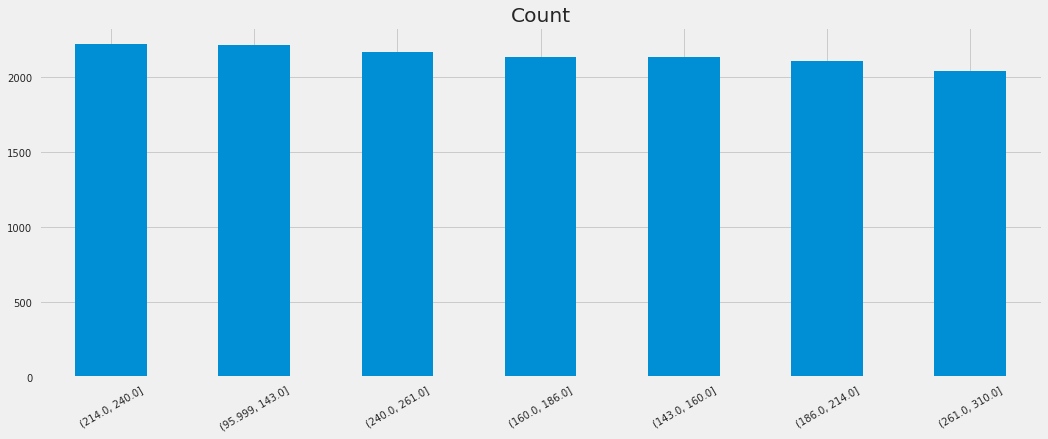

In [36]:
##Lets do binning
df['hours_bins'] = pd.qcut(df['average_montly_hours'],7)

##Plot to check the binning
df['hours_bins'].value_counts().plot(kind = 'bar',figsize = (16,6))
plt.title("Count")
plt.xticks(rotation = 30)

#Bins are distributed evenly.
df.head()

,satisfaction,evaluation,number_of_projects,average_montly_hours,time_spend_company,work_accident,churn,promotion,department,salary,work_load,if_changes,dept_vul,hours_bins,hours_per_project
0,0.38,0.53,2,157,3,0,1,0,sales,low,0,1,1,"(143.0, 160.0]",78
1,0.80,0.86,5,262,6,0,1,0,sales,medium,1,1,1,"(261.0, 310.0]",52
2,0.11,0.88,7,272,4,0,1,0,sales,medium,2,1,1,"(261.0, 310.0]",38
3,0.72,0.87,5,223,5,0,1,0,sales,low,1,1,1,"(214.0, 240.0]",44
4,0.37,0.52,2,159,3,0,1,0,sales,low,0,1,1,"(143.0, 160.0]",79


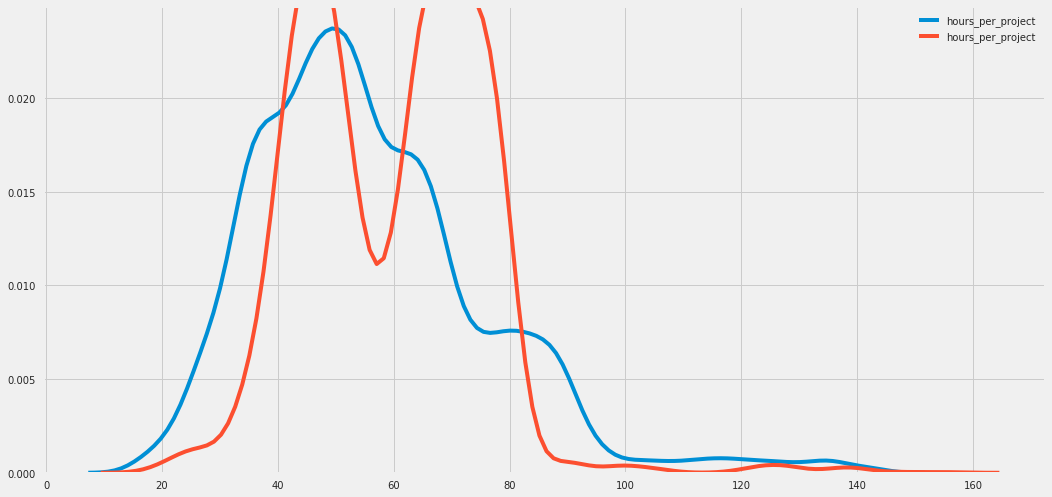

In [37]:
##Feature per project hours
df['hours_per_project'] = df['average_montly_hours']//df['number_of_projects']

##Checking the distribution
plt.figure(figsize = (16,8))
sns.kdeplot(df.loc[df['churn'] == 0,'hours_per_project'].dropna())   #Blue
sns.kdeplot(df.loc[df['churn'] == 1,'hours_per_project'].dropna())   #Red

##we can  do some analysis on the hours_per_project
df.head()

In [38]:
## we can even do bining hare
df['bins_hours_project'] = pd.qcut(df['hours_per_project'],13)
df['bins_hours_project'].value_counts()
df.head()

,satisfaction,evaluation,number_of_projects,average_montly_hours,time_spend_company,work_accident,churn,promotion,department,salary,work_load,if_changes,dept_vul,hours_bins,hours_per_project,bins_hours_project
0,0.38,0.53,2,157,3,0,1,0,sales,low,0,1,1,"(143.0, 160.0]",78,"(75.0, 83.0]"
1,0.80,0.86,5,262,6,0,1,0,sales,medium,1,1,1,"(261.0, 310.0]",52,"(49.0, 52.0]"
2,0.11,0.88,7,272,4,0,1,0,sales,medium,2,1,1,"(261.0, 310.0]",38,"(34.0, 38.0]"
3,0.72,0.87,5,223,5,0,1,0,sales,low,1,1,1,"(214.0, 240.0]",44,"(43.0, 46.0]"
4,0.37,0.52,2,159,3,0,1,0,sales,low,0,1,1,"(143.0, 160.0]",79,"(75.0, 83.0]"


## More Feature Engineering   
In this section we are going to create more features   
Based on the statistics and transformations.  

we'll be creating dummy variables and some label encoding will be done .

We'll make all the features such that,it should be suitable for machine learning modelling.

In [39]:
##making feature for average monthy hours by using aggegrations
monthly_hrs = df.groupby('department')['average_montly_hours'].agg(['min','max','std','mean']).reset_index()
monthly_hrs.columns = ['department','monthly_min_hours','monthly_max_hours','monthly_std_hours','monthly_mean_hours']

df = pd.merge(df,monthly_hrs,on = 'department')
df.head()


,satisfaction,evaluation,number_of_projects,average_montly_hours,time_spend_company,work_accident,churn,promotion,department,salary,work_load,if_changes,dept_vul,hours_bins,hours_per_project,bins_hours_project,monthly_min_hours,monthly_max_hours,monthly_std_hours,monthly_mean_hours
0,0.38,0.53,2,157,3,0,1,0,sales,low,0,1,1,"(143.0, 160.0]",78,"(75.0, 83.0]",96,310,49.560393,200.911353
1,0.80,0.86,5,262,6,0,1,0,sales,medium,1,1,1,"(261.0, 310.0]",52,"(49.0, 52.0]",96,310,49.560393,200.911353
2,0.11,0.88,7,272,4,0,1,0,sales,medium,2,1,1,"(261.0, 310.0]",38,"(34.0, 38.0]",96,310,49.560393,200.911353
3,0.72,0.87,5,223,5,0,1,0,sales,low,1,1,1,"(214.0, 240.0]",44,"(43.0, 46.0]",96,310,49.560393,200.911353
4,0.37,0.52,2,159,3,0,1,0,sales,low,0,1,1,"(143.0, 160.0]",79,"(75.0, 83.0]",96,310,49.560393,200.911353


In [40]:
##making feature salary using average monthy hours
sal_monthly_hrs = df.groupby('salary')['average_montly_hours'].agg(['min','max','std','mean']).reset_index()
sal_monthly_hrs.columns = ['salary','smonthly_min_hours','smonthly_max_hours','smonthly_std_hours','smonthly_mean_hours']

full_df = pd.merge(df,sal_monthly_hrs,on = 'salary')
full_df.head()


,satisfaction,evaluation,number_of_projects,average_montly_hours,time_spend_company,work_accident,churn,promotion,department,salary,work_load,if_changes,dept_vul,hours_bins,hours_per_project,bins_hours_project,monthly_min_hours,monthly_max_hours,monthly_std_hours,monthly_mean_hours,smonthly_min_hours,smonthly_max_hours,smonthly_std_hours,smonthly_mean_hours
0,0.38,0.53,2,157,3,0,1,0,sales,low,0,1,1,"(143.0, 160.0]",78,"(75.0, 83.0]",96,310,49.560393,200.911353,96,310,50.832214,200.996583
1,0.72,0.87,5,223,5,0,1,0,sales,low,1,1,1,"(214.0, 240.0]",44,"(43.0, 46.0]",96,310,49.560393,200.911353,96,310,50.832214,200.996583
2,0.37,0.52,2,159,3,0,1,0,sales,low,0,1,1,"(143.0, 160.0]",79,"(75.0, 83.0]",96,310,49.560393,200.911353,96,310,50.832214,200.996583
3,0.41,0.50,2,153,3,0,1,0,sales,low,0,1,1,"(143.0, 160.0]",76,"(75.0, 83.0]",96,310,49.560393,200.911353,96,310,50.832214,200.996583
4,0.10,0.77,6,247,4,0,1,0,sales,low,2,1,1,"(240.0, 261.0]",41,"(38.0, 43.0]",96,310,49.560393,200.911353,96,310,50.832214,200.996583


In [41]:
##making features based on department

aggegrations = {'time_spend_company':['sum','mean','std'],
               'number_of_projects':['max','min','sum'],
               'evaluation':['mean','std'],
               'satisfaction':['mean','std'],
               'hours_per_project':['sum','mean','std','max','min'],
               'dept_vul':['sum'],
               'work_load':['sum']}

dept_feat = df.groupby('department')['time_spend_company','number_of_projects','evaluation',
                                          'satisfaction','hours_per_project','dept_vul','work_load'].agg(aggegrations).reset_index()
                                                                                         
dept_feat

##The more the number of projects in the department the most the employees will leave.

department time_spend_company                     number_of_projects      \
                              sum      mean       std                max min   
0           IT               4256  3.468623  1.408302                  7   2   
1        RandD               2650  3.367217  1.214247                  7   2   
2   accounting               2702  3.522816  1.404650                  7   2   
3           hr               2480  3.355886  1.169510                  7   2   
4   management               2711  4.303175  2.425715                  7   2   
5    marketing               3063  3.569930  1.536907                  7   2   
6  product_mng               3135  3.475610  1.428644                  7   2   
7        sales              14631  3.534058  1.512307                  7   2   
8      support               7563  3.393001  1.340860                  7   2   
9    technical               9279  3.411397  1.262619                  7   2   

         evaluation           satisfaction           hours_per_project  \
     sum       mean       std         mean       std               sum   
0   4683   0.716830  0.164508     0.618142  0.249903             69443   
1   3033   0.712122  0.165093     0.619822  0.245269             43570   
2   2934   0.717718  0.171904     0.582151  0.255235             43314   
3   2701   0.708850  0.174584     0.598809  0.247929             42850   
4   2432   0.724000  0.160263     0.621349  0.227747             35396   
5   3164   0.715886  0.173447     0.618601  0.244280             49619   
6   3434   0.714756  0.178147     0.619634  0.242279             51195   
7  15634   0.709717  0.171459     0.614447  0.250251            237382   
8   8479   0.723109  0.171224     0.618300  0.246406            125742   
9  10548   0.721099  0.173364     0.607897  0.254193            152352   

                                 dept_vul work_load  
        mean        std  max min      sum       sum  
0  56.595762  18.707622  142  17     1227      1160  
1  55.362135  18.173107  142  17      787       765  
2  56.471969  18.788612  140  19        0       722  
3  57.983762  17.726613  142  16        0       666  
4  56.184127  20.414257  135  16     1260       606  
5  57.831002  18.566368  143  16      858       770  
6  56.757206  20.195708  155  16      902       840  
7  57.338647  19.750578  148  16     4140      3811  
8  56.411844  18.321999  142  16     2229      2079  
9  56.011765  18.864216  142  16        0      2622

In [42]:
##Features based on salary
salary_feat = df.groupby('salary')['time_spend_company','number_of_projects','evaluation',
                                          'satisfaction','hours_per_project','dept_vul','work_load'].agg(aggegrations).reset_index()
                                                                                         
salary_feat

salary time_spend_company                     number_of_projects      \
                         sum      mean       std                max min   
0    high               4568  3.692805  1.977885                  7   2   
1     low              25154  3.438218  1.303818                  7   2   
2  medium              22748  3.529010  1.506442                  7   2   

         evaluation           satisfaction           hours_per_project  \
     sum       mean       std         mean       std               sum   
0   4660   0.704325  0.158608     0.637470  0.226791             70262   
1  27800   0.717017  0.173261     0.600753  0.254594            416770   
2  24582   0.717322  0.171043     0.621817  0.245069            363831   

                                 dept_vul work_load  
        mean        std  max min      sum       sum  
0  56.800323  20.104051  142  17     1142      1173  
1  56.966922  19.109405  155  16     5431      6749  
2  56.442910  18.814568  148  16     4830      6119

In [43]:
##Merging these features to our dataframe df
##lets define the columns names
salary_feat.columns = pd.Index([e[0]+"__"+e[1].upper() for e in salary_feat.columns.tolist()])
print(salary_feat.columns)
dept_feat.columns = pd.Index([e[0]+"_+_"+e[1].upper() for e in dept_feat.columns.tolist()])
print(dept_feat.columns)

Index(['salary__', 'time_spend_company__SUM', 'time_spend_company__MEAN',
       'time_spend_company__STD', 'number_of_projects__MAX',
       'number_of_projects__MIN', 'number_of_projects__SUM',
       'evaluation__MEAN', 'evaluation__STD', 'satisfaction__MEAN',
       'satisfaction__STD', 'hours_per_project__SUM',
       'hours_per_project__MEAN', 'hours_per_project__STD',
       'hours_per_project__MAX', 'hours_per_project__MIN', 'dept_vul__SUM',
       'work_load__SUM'],
      dtype='object')
Index(['department_+_', 'time_spend_company_+_SUM',
       'time_spend_company_+_MEAN', 'time_spend_company_+_STD',
       'number_of_projects_+_MAX', 'number_of_projects_+_MIN',
       'number_of_projects_+_SUM', 'evaluation_+_MEAN', 'evaluation_+_STD',
       'satisfaction_+_MEAN', 'satisfaction_+_STD', 'hours_per_project_+_SUM',
       'hours_per_project_+_MEAN', 'hours_per_project_+_STD',
       'hours_per_project_+_MAX', 'hours_per_project_+_MIN', 'dept_vul_+_SUM',
       'work_load_+_SUM

In [44]:
##Merging
pd.options.display.max_columns = 150
df = pd.merge(df,dept_feat,left_on = 'department',right_on = 'department_+_')
df = pd.merge(df,salary_feat,left_on = 'salary',right_on = 'salary__')
df.head()

,satisfaction,evaluation,number_of_projects,average_montly_hours,time_spend_company,work_accident,churn,promotion,department,salary,work_load,if_changes,dept_vul,hours_bins,hours_per_project,bins_hours_project,monthly_min_hours,monthly_max_hours,monthly_std_hours,monthly_mean_hours,department_+_,time_spend_company_+_SUM,time_spend_company_+_MEAN,time_spend_company_+_STD,number_of_projects_+_MAX,number_of_projects_+_MIN,number_of_projects_+_SUM,evaluation_+_MEAN,evaluation_+_STD,satisfaction_+_MEAN,satisfaction_+_STD,hours_per_project_+_SUM,hours_per_project_+_MEAN,hours_per_project_+_STD,hours_per_project_+_MAX,hours_per_project_+_MIN,dept_vul_+_SUM,work_load_+_SUM,salary__,time_spend_company__SUM,time_spend_company__MEAN,time_spend_company__STD,number_of_projects__MAX,number_of_projects__MIN,number_of_projects__SUM,evaluation__MEAN,evaluation__STD,satisfaction__MEAN,satisfaction__STD,hours_per_project__SUM,hours_per_project__MEAN,hours_per_project__STD,hours_per_project__MAX,hours_per_project__MIN,dept_vul__SUM,work_load__SUM
0,0.38,0.53,2,157,3,0,1,0,sales,low,0,1,1,"(143.0, 160.0]",78,"(75.0, 83.0]",96,310,49.560393,200.911353,sales,14631,3.534058,1.512307,7,2,15634,0.709717,0.171459,0.614447,0.250251,237382,57.338647,19.750578,148,16,4140,3811,low,25154,3.438218,1.303818,7,2,27800,0.717017,0.173261,0.600753,0.254594,416770,56.966922,19.109405,155,16,5431,6749
1,0.72,0.87,5,223,5,0,1,0,sales,low,1,1,1,"(214.0, 240.0]",44,"(43.0, 46.0]",96,310,49.560393,200.911353,sales,14631,3.534058,1.512307,7,2,15634,0.709717,0.171459,0.614447,0.250251,237382,57.338647,19.750578,148,16,4140,3811,low,25154,3.438218,1.303818,7,2,27800,0.717017,0.173261,0.600753,0.254594,416770,56.966922,19.109405,155,16,5431,6749
2,0.37,0.52,2,159,3,0,1,0,sales,low,0,1,1,"(143.0, 160.0]",79,"(75.0, 83.0]",96,310,49.560393,200.911353,sales,14631,3.534058,1.512307,7,2,15634,0.709717,0.171459,0.614447,0.250251,237382,57.338647,19.750578,148,16,4140,3811,low,25154,3.438218,1.303818,7,2,27800,0.717017,0.173261,0.600753,0.254594,416770,56.966922,19.109405,155,16,5431,6749
3,0.41,0.50,2,153,3,0,1,0,sales,low,0,1,1,"(143.0, 160.0]",76,"(75.0, 83.0]",96,310,49.560393,200.911353,sales,14631,3.534058,1.512307,7,2,15634,0.709717,0.171459,0.614447,0.250251,237382,57.338647,19.750578,148,16,4140,3811,low,25154,3.438218,1.303818,7,2,27800,0.717017,0.173261,0.600753,0.254594,416770,56.966922,19.109405,155,16,5431,6749
4,0.10,0.77,6,247,4,0,1,0,sales,low,2,1,1,"(240.0, 261.0]",41,"(38.0, 43.0]",96,310,49.560393,200.911353,sales,14631,3.534058,1.512307,7,2,15634,0.709717,0.171459,0.614447,0.250251,237382,57.338647,19.750578,148,16,4140,3811,low,25154,3.438218,1.303818,7,2,27800,0.717017,0.173261,0.600753,0.254594,416770,56.966922,19.109405,155,16,5431,6749


In [45]:
##Creating more features for True/False like features
## for work_accident
accident = df[df['work_accident'] == 1]
accident_dept = accident.groupby('department')['time_spend_company','number_of_projects','evaluation',
                                          'satisfaction','hours_per_project','dept_vul','work_load'].agg(aggegrations).reset_index()

accident_salary = accident.groupby('salary')['time_spend_company','number_of_projects','evaluation',
                                          'satisfaction','hours_per_project','dept_vul','work_load'].agg(aggegrations).reset_index()

##for promotion
promo = df[df['promotion'] == 1]
promo_dept = promo.groupby('department')['time_spend_company','number_of_projects','evaluation',
                                          'satisfaction','hours_per_project','dept_vul','work_load'].agg(aggegrations).reset_index()

promo_salary = promo.groupby('salary')['time_spend_company','number_of_projects','evaluation',
                                          'satisfaction','hours_per_project','dept_vul','work_load'].agg(aggegrations).reset_index()


##for if_changes
changes = df[df['if_changes'] == 1]
changes_dept = changes.groupby('department')['time_spend_company','number_of_projects','evaluation',
                                          'satisfaction','hours_per_project','dept_vul','work_load'].agg(aggegrations).reset_index()

changes_salary = changes.groupby('salary')['time_spend_company','number_of_projects','evaluation',
                                          'satisfaction','hours_per_project','dept_vul','work_load'].agg(aggegrations).reset_index()


In [46]:
##Renaming the columns
accident_dept.columns = pd.Index([e[0]+"_-_"+e[1].upper() for e in accident_dept.columns.tolist()])
print(accident_dept.columns)
accident_salary.columns = pd.Index([e[0]+"_+"+e[1].upper() for e in accident_salary.columns.tolist()])
print(accident_salary.columns)

promo_dept.columns = pd.Index([e[0]+"+_"+e[1].upper() for e in promo_dept.columns.tolist()])
print(promo_dept.columns)
promo_salary.columns = pd.Index([e[0]+"+_"+e[1].upper() for e in promo_salary.columns.tolist()])
print(promo_salary.columns)

changes_dept.columns = pd.Index([e[0]+"+"+e[1].upper() for e in changes_dept.columns.tolist()])
print(changes_dept.columns)
changes_salary.columns = pd.Index([e[0]+"&"+e[1].upper() for e in changes_salary.columns.tolist()])
print(changes_salary.columns)

Index(['department_-_', 'time_spend_company_-_SUM',
       'time_spend_company_-_MEAN', 'time_spend_company_-_STD',
       'number_of_projects_-_MAX', 'number_of_projects_-_MIN',
       'number_of_projects_-_SUM', 'evaluation_-_MEAN', 'evaluation_-_STD',
       'satisfaction_-_MEAN', 'satisfaction_-_STD', 'hours_per_project_-_SUM',
       'hours_per_project_-_MEAN', 'hours_per_project_-_STD',
       'hours_per_project_-_MAX', 'hours_per_project_-_MIN', 'dept_vul_-_SUM',
       'work_load_-_SUM'],
      dtype='object')
Index(['salary_+', 'time_spend_company_+SUM', 'time_spend_company_+MEAN',
       'time_spend_company_+STD', 'number_of_projects_+MAX',
       'number_of_projects_+MIN', 'number_of_projects_+SUM',
       'evaluation_+MEAN', 'evaluation_+STD', 'satisfaction_+MEAN',
       'satisfaction_+STD', 'hours_per_project_+SUM',
       'hours_per_project_+MEAN', 'hours_per_project_+STD',
       'hours_per_project_+MAX', 'hours_per_project_+MIN', 'dept_vul_+SUM',
       'work_load_+SUM

In [47]:
##Merging the dataframes
df = pd.merge(df,accident_dept,left_on = 'department',right_on = 'department_-_')
df = pd.merge(df,accident_salary,left_on = 'salary',right_on = 'salary_+')

df = pd.merge(df,promo_dept,left_on = 'department',right_on = 'department+_')
df = pd.merge(df,promo_salary,left_on = 'salary',right_on = 'salary+_')

df = pd.merge(df,changes_dept,left_on = 'department',right_on = 'department+')
df = pd.merge(df,changes_salary,left_on = 'salary',right_on = 'salary&')

In [48]:
##count of promotion department wise
ct_dept = df.groupby('department')['promotion'].agg({'promotion':'sum'}).reset_index()
ct_dept.columns = ['department','no_of_promotions']

df = pd.merge(df,ct_dept,on = 'department')
df.head()

/home/ankit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,satisfaction,evaluation,number_of_projects,average_montly_hours,time_spend_company,work_accident,churn,promotion,department,salary,work_load,if_changes,dept_vul,hours_bins,hours_per_project,bins_hours_project,monthly_min_hours,monthly_max_hours,monthly_std_hours,monthly_mean_hours,department_+_,time_spend_company_+_SUM,time_spend_company_+_MEAN,time_spend_company_+_STD,number_of_projects_+_MAX,number_of_projects_+_MIN,number_of_projects_+_SUM,evaluation_+_MEAN,evaluation_+_STD,satisfaction_+_MEAN,satisfaction_+_STD,hours_per_project_+_SUM,hours_per_project_+_MEAN,hours_per_project_+_STD,hours_per_project_+_MAX,hours_per_project_+_MIN,dept_vul_+_SUM,work_load_+_SUM,salary__,time_spend_company__SUM,time_spend_company__MEAN,time_spend_company__STD,number_of_projects__MAX,number_of_projects__MIN,number_of_projects__SUM,evaluation__MEAN,evaluation__STD,satisfaction__MEAN,satisfaction__STD,hours_per_project__SUM,hours_per_project__MEAN,hours_per_project__STD,hours_per_project__MAX,hours_per_project__MIN,dept_vul__SUM,work_load__SUM,department_-_,time_spend_company_-_SUM,time_spend_company_-_MEAN,time_spend_company_-_STD,number_of_projects_-_MAX,number_of_projects_-_MIN,number_of_projects_-_SUM,evaluation_-_MEAN,evaluation_-_STD,satisfaction_-_MEAN,satisfaction_-_STD,hours_per_project_-_SUM,hours_per_project_-_MEAN,hours_per_project_-_STD,hours_per_project_-_MAX,hours_per_project_-_MIN,dept_vul_-_SUM,work_load_-_SUM,salary_+,...,dept_vul_+SUM,work_load_+SUM,department+_,time_spend_company+_SUM_x,time_spend_company+_MEAN_x,time_spend_company+_STD_x,number_of_projects+_MAX_x,number_of_projects+_MIN_x,number_of_projects+_SUM_x,evaluation+_MEAN_x,evaluation+_STD_x,satisfaction+_MEAN_x,satisfaction+_STD_x,hours_per_project+_SUM_x,hours_per_project+_MEAN_x,hours_per_project+_STD_x,hours_per_project+_MAX_x,hours_per_project+_MIN_x,dept_vul+_SUM_x,work_load+_SUM_x,salary+_,time_spend_company+_SUM_y,time_spend_company+_MEAN_y,time_spend_company+_STD_y,number_of_projects+_MAX_y,number_of_projects+_MIN_y,number_of_projects+_SUM_y,evaluation+_MEAN_y,evaluation+_STD_y,satisfaction+_MEAN_y,satisfaction+_STD_y,hours_per_project+_SUM_y,hours_per_project+_MEAN_y,hours_per_project+_STD_y,hours_per_project+_MAX_y,hours_per_project+_MIN_y,dept_vul+_SUM_y,work_load+_SUM_y,department+,time_spend_company+SUM,time_spend_company+MEAN,time_spend_company+STD,number_of_projects+MAX,number_of_projects+MIN,number_of_projects+SUM,evaluation+MEAN,evaluation+STD,satisfaction+MEAN,satisfaction+STD,hours_per_project+SUM,hours_per_project+MEAN,hours_per_project+STD,hours_per_project+MAX,hours_per_project+MIN,dept_vul+SUM,work_load+SUM,salary&,time_spend_company&SUM,time_spend_company&MEAN,time_spend_company&STD,number_of_projects&MAX,number_of_projects&MIN,number_of_projects&SUM,evaluation&MEAN,evaluation&STD,satisfaction&MEAN,satisfaction&STD,hours_per_project&SUM,hours_per_project&MEAN,hours_per_project&STD,hours_per_project&MAX,hours_per_project&MIN,dept_vul&SUM,work_load&SUM,no_of_promotions
0,0.38,0.53,2,157,3,0,1,0,sales,low,0,1,1,"(143.0, 160.0]",78,"(75.0, 83.0]",96,310,49.560393,200.911353,sales,14631,3.534058,1.512307,7,2,15634,0.709717,0.171459,0.614447,0.250251,237382,57.338647,19.750578,148,16,4140,3811,low,25154,3.438218,1.303818,7,2,27800,0.717017,0.173261,0.600753,0.254594,416770,56.966922,19.109405,155,16,5431,6749,sales,2045,3.483816,1.675255,6,2,2205,0.702538,0.168156,0.644906,0.23986,33950,57.836457,21.952178,139,16,587,555,low,...,789,1000,sales,351,3.51,1.480479,6,2,379,0.7254,0.173836,0.7085,0.19234,5752,57.52,18.460704,122,28,100,95,low,249,3.772727,1.475914,6,2,227,0.679394,0.169242,0.626818,0.210554,3893,58.984848,17.719604,89,26,57,58,sales,11093,3.670748,0.924741,7,2,11482,0.710414,0.177364,0.584017,0.25952,173633,57.45632,19.63043,148,16,3022,2740,low,20808,3.691325,0.922753,7,2,21580,0.716592,0.177023,0.572737,0.264551,321188,56.978535,18.856817,155,16,4153,5140,100
1,0.72,0.87,5,223,5,0,1,0,sales,low,1,1,1,"(214.0, 240.0]",44,"(43.0, 46.

In [49]:
##Creating dummy variables
cols_for_dummy_variables = ['number_of_projects','time_spend_company','department','salary',
                           'dept_vul','hours_bins','bins_hours_project']
for feat in cols_for_dummy_variables:
    dummy_df = pd.get_dummies(df[feat],prefix = feat)
    df = pd.concat([df,dummy_df],axis = 1)
    
df.head()

,satisfaction,evaluation,number_of_projects,average_montly_hours,time_spend_company,work_accident,churn,promotion,department,salary,work_load,if_changes,dept_vul,hours_bins,hours_per_project,bins_hours_project,monthly_min_hours,monthly_max_hours,monthly_std_hours,monthly_mean_hours,department_+_,time_spend_company_+_SUM,time_spend_company_+_MEAN,time_spend_company_+_STD,number_of_projects_+_MAX,number_of_projects_+_MIN,number_of_projects_+_SUM,evaluation_+_MEAN,evaluation_+_STD,satisfaction_+_MEAN,satisfaction_+_STD,hours_per_project_+_SUM,hours_per_project_+_MEAN,hours_per_project_+_STD,hours_per_project_+_MAX,hours_per_project_+_MIN,dept_vul_+_SUM,work_load_+_SUM,salary__,time_spend_company__SUM,time_spend_company__MEAN,time_spend_company__STD,number_of_projects__MAX,number_of_projects__MIN,number_of_projects__SUM,evaluation__MEAN,evaluation__STD,satisfaction__MEAN,satisfaction__STD,hours_per_project__SUM,hours_per_project__MEAN,hours_per_project__STD,hours_per_project__MAX,hours_per_project__MIN,dept_vul__SUM,work_load__SUM,department_-_,time_spend_company_-_SUM,time_spend_company_-_MEAN,time_spend_company_-_STD,number_of_projects_-_MAX,number_of_projects_-_MIN,number_of_projects_-_SUM,evaluation_-_MEAN,evaluation_-_STD,satisfaction_-_MEAN,satisfaction_-_STD,hours_per_project_-_SUM,hours_per_project_-_MEAN,hours_per_project_-_STD,hours_per_project_-_MAX,hours_per_project_-_MIN,dept_vul_-_SUM,work_load_-_SUM,salary_+,...,hours_per_project+SUM,hours_per_project+MEAN,hours_per_project+STD,hours_per_project+MAX,hours_per_project+MIN,dept_vul+SUM,work_load+SUM,salary&,time_spend_company&SUM,time_spend_company&MEAN,time_spend_company&STD,number_of_projects&MAX,number_of_projects&MIN,number_of_projects&SUM,evaluation&MEAN,evaluation&STD,satisfaction&MEAN,satisfaction&STD,hours_per_project&SUM,hours_per_project&MEAN,hours_per_project&STD,hours_per_project&MAX,hours_per_project&MIN,dept_vul&SUM,work_load&SUM,no_of_promotions,number_of_projects_2,number_of_projects_3,number_of_projects_4,number_of_projects_5,number_of_projects_6,number_of_projects_7,time_spend_company_2,time_spend_company_3,time_spend_company_4,time_spend_company_5,time_spend_company_6,time_spend_company_7,time_spend_company_8,time_spend_company_10,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium,dept_vul_0,dept_vul_1,dept_vul_2,"hours_bins_(95.999, 143.0]","hours_bins_(143.0, 160.0]","hours_bins_(160.0, 186.0]","hours_bins_(186.0, 214.0]","hours_bins_(214.0, 240.0]","hours_bins_(240.0, 261.0]","hours_bins_(261.0, 310.0]","bins_hours_project_(15.999, 34.0]","bins_hours_project_(34.0, 38.0]","bins_hours_project_(38.0, 43.0]","bins_hours_project_(43.0, 46.0]","bins_hours_project_(46.0, 49.0]","bins_hours_project_(49.0, 52.0]","bins_hours_project_(52.0, 56.0]","bins_hours_project_(56.0, 61.0]","bins_hours_project_(61.0, 65.0]","bins_hours_project_(65.0, 69.0]","bins_hours_project_(69.0, 75.0]","bins_hours_project_(75.0, 83.0]","bins_hours_project_(83.0, 155.0]"
0,0.38,0.53,2,157,3,0,1,0,sales,low,0,1,1,"(143.0, 160.0]",78,"(75.0, 83.0]",96,310,49.560393,200.911353,sales,14631,3.534058,1.512307,7,2,15634,0.709717,0.171459,0.614447,0.250251,237382,57.338647,19.750578,148,16,4140,3811,low,25154,3.438218,1.303818,7,2,27800,0.717017,0.173261,0.600753,0.254594,416770,56.966922,19.109405,155,16,5431,6749,sales,2045,3.483816,1.675255,6,2,2205,0.702538,0.168156,0.644906,0.23986,33950,57.836457,21.952178,139,16,587,555,low,...,173633,57.45632,19.63043,148,16,3022,2740,low,20808,3.691325,0.922753,7,2,21580,0.716592,0.177023,0.572737,0.264551,321188,56.978535,18.856817,155,16,4153,5140,100,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.72,0.87,5,223,5,0,1,0,sales,low,1,1,1,"(214.0, 240.0]",44,"(43.0, 46.0]",96,310,49.560393,200.911353,sales,14631,3.534058,1.512307,7,2,15634,0

In [50]:
##Deleting the redundant columns
df.drop(cols_for_dummy_variables,axis = 1,inplace = True)

In [51]:
##Current shape of the dataframe 
df.shape

(14097, 207)

In [52]:
object_cols = df.select_dtypes(['object'])
df.drop(object_cols.columns,axis = 1,inplace = True)

# Machine Larning Modelling
Once feature engineering/construction is done, we can get started with the machine learning! All of our data (both training and testing) is aggregated for each household and so can be directly used in a model. To first show the process of modeling, we'll use the capable Random Forest Classifier in Scikit-Learn. This probably won't get us to the top of the leaderboard, but it will allow us to establish a baseline. Later we'll try several other models including the powerful Gradient Boosting Machine.

To assess our model, we'll use 10-fold cross validation on the training data. This will essentially train and test the model 10 times using different splits of the training data. 10-fold cross validation is an effective method for estimating the performance of a model on the test set. We want to look at the average performance in cross validation as well as the standard deviation to see how much scores change between the folds. We use the F1 Macro measure to evaluate performance. 

In [53]:
##As we have binary classification problem
target = df['churn']
del df['churn']

In [54]:
##Creating array so as to feed in the algorithms
X = df.iloc[:,:].values
y = target.values

In [55]:
##StandardScaling

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)


In [56]:
## generating train and test 
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = .10,stratify  =y,random_state = 42)

### BaseLine Model  
we are going to create the base line model to check the performance of the feature engineering phase. 

In [57]:
##random Forest
from sklearn.ensemble import RandomForestClassifier
##using default parameters
clf = RandomForestClassifier()
clf.fit(X_train,y_train)

##Prediction
y_base_line = clf.predict(X_test)

In [58]:
##getting the score
from sklearn.metrics import accuracy_score
score = accuracy_score(y_base_line,y_test)
score


# we have nice score but this is not important lets check the confusion matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_base_line,y_test)
print(cm)


[[1065   25]
 [   8  312]]


[[1065   25]
 [   8  312]]


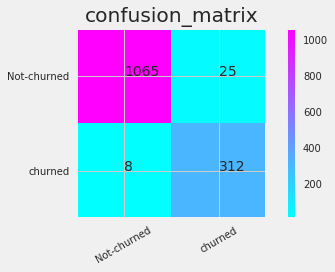

In [59]:
##Let's make a function to plot the confusion matrix
import itertools

def plot_cm(y_pred,y_true,classes,cmap = plt.cm.cool):
    cm = confusion_matrix(y_pred,y_true)
    print(cm)
    plt.imshow(cm,interpolation = 'nearest',cmap = cmap)
    plt.title('confusion_matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation = 30)
    plt.yticks(tick_marks,classes)
    
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j]))
        
    plt.tight_layout()

plot_cm(y_base_line,y_test,classes = ['Not-churned','churned'])

#### Explanation  
we have type-1 error count is 20 and type-2 erroe count is 4.  
In our subsequent modelling our aim would be to minimize these errors.  
Type -2 error is more dangerous as it is telling that these employees would not churn but actually they churned thus loss to the company.  
Type-2 Error is also called as False Negative.  
Type-1 Error is called as false Positive.  
In problems like these where we have imbalanced classes we calculate precision.  

### Feature Importances using BaseLine Model  
It is calculated as How much the tree nodes use a perticular feature(weighted average) to reduce impurity.  

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

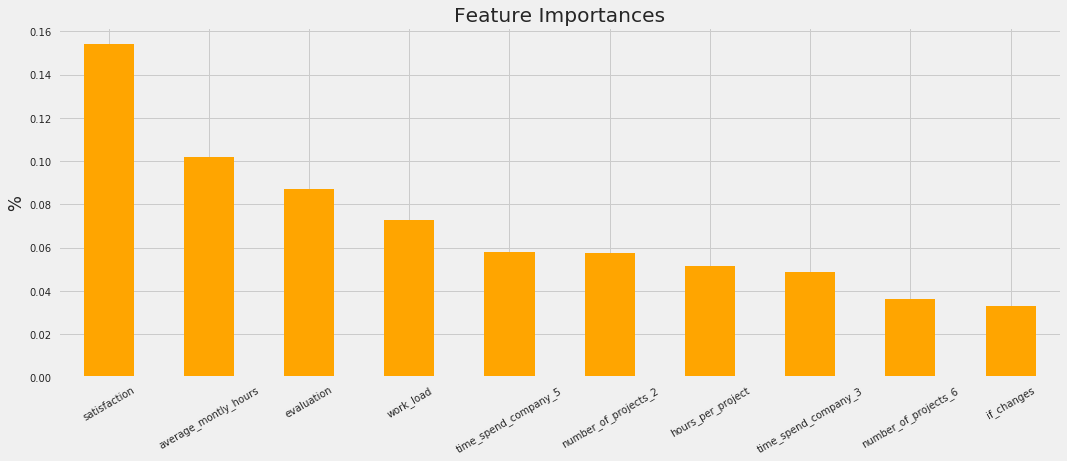

In [60]:
feature_importances = pd.Series(clf.feature_importances_,index = df.columns).sort_values(ascending = False)[:10]
feature_importances.plot(kind = 'bar',figsize = (16,6),color = 'orange')
plt.title("Feature Importances")
plt.ylabel("%")
plt.xticks(rotation = 30)

**Thus we see that many of our created features are in the Top-10 list.  
that's motivating for us.**

### Model Selection
In this section we'll be using different machine learning model and calculate the precision score.


In [61]:
# Model imports
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer,precision_score,roc_auc_score,f1_score,recall_score

# Custom scorer for cross validation
#scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')
scorer_p = make_scorer(precision_score)
socrer_r = make_scorer(recall_score)
scorer_f1= make_scorer(f1_score)


In [62]:
# Dataframe to hold results
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

def cv_model(train, train_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    
    cv_scores = cross_val_score(model, train, train_labels, cv = 10, scoring=scorer_f1, n_jobs = -1)
    print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_mean': cv_scores.mean(), 
                                                            'cv_std': cv_scores.std()},
                                                           index = [0]),
                                             ignore_index = True)

        return model_results


In [63]:
##Using Logistic Regression
model_results = cv_model(X_train,y_train,LogisticRegression(),'Logistic Regression',model_results)

10 Fold CV Score: 0.86955 with std: 0.01569


In [64]:
##Using gaussiannb
model_results = cv_model(X_train,y_train,GaussianNB(),'gaussian_nb',model_results)
##Really poor

10 Fold CV Score: 0.52788 with std: 0.01069


In [65]:
##using MLPCLassifier
model_results = cv_model(X_train,y_train,MLPClassifier(),'mlpclassifier',model_results)
##Improved

10 Fold CV Score: 0.93326 with std: 0.013


In [66]:
##Using support vector machine 
model_results = cv_model(X_train,y_train,LinearSVC(),'Linear SVC',model_results)

10 Fold CV Score: 0.86809 with std: 0.01416


In [67]:
##Using LogisticRegressionCV
model_results = cv_model(X_train,y_train,LogisticRegressionCV(),'Logistic CV',model_results)

10 Fold CV Score: 0.87172 with std: 0.01565


In [68]:
##Using RidgeClassifierCV
model_results = cv_model(X_train,y_train,RidgeClassifierCV(),'RidgeClassification',model_results)

10 Fold CV Score: 0.83997 with std: 0.01359


In [69]:
##KNN
for n in [5, 10, 20]:
    print(f'\nKNN with {n} neighbors\n')
    model_results = cv_model(X_train, y_train, 
                             KNeighborsClassifier(n_neighbors = n),
                             f'knn-{n}', model_results)


KNN with 5 neighbors

10 Fold CV Score: 0.84098 with std: 0.01435

KNN with 10 neighbors

10 Fold CV Score: 0.833 with std: 0.01616

KNN with 20 neighbors

10 Fold CV Score: 0.79949 with std: 0.00954


In [70]:
##Using ExtraTree Classifiers
from sklearn.ensemble import ExtraTreesClassifier
model_results = cv_model(X_train,y_train,ExtraTreesClassifier(n_estimators = 200,random_state = 42),'EXT',model_results)

10 Fold CV Score: 0.95373 with std: 0.01175


In [71]:
##Using Randomly Tuned RandomForest
model_results = cv_model(X_train,y_train,RandomForestClassifier(n_estimators = 300,
                                                                max_depth = 7,
                                                                random_state = 43
),"RandomForest",model_results)

##so far the best one.

10 Fold CV Score: 0.85618 with std: 0.00418


#### Comparing Models

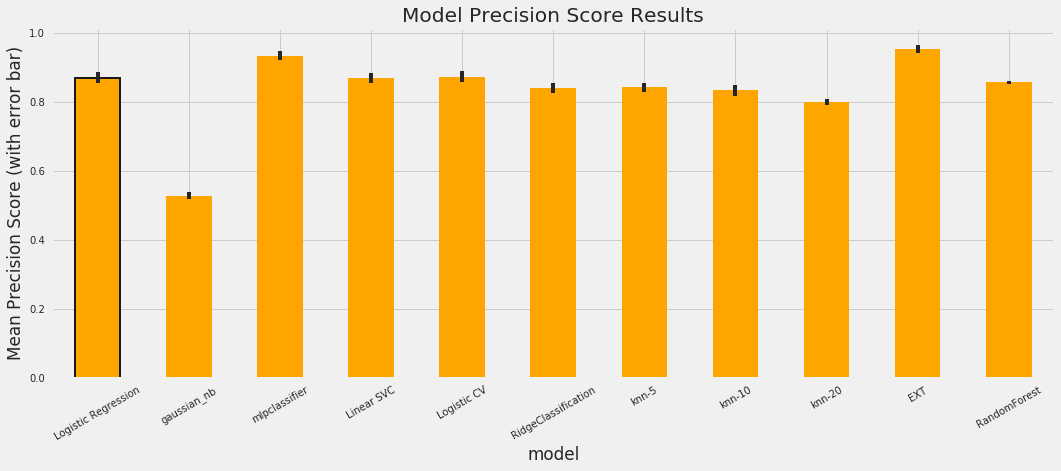

In [72]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (16, 6),
                                  yerr = list(model_results['cv_std']),
                                  edgecolor = 'k', linewidth = 2)
plt.title('Model Precision Score Results')
plt.xticks(rotation = 30)
plt.ylabel('Mean Precision Score (with error bar)')
model_results.reset_index(inplace = True)

### Voting Classifier  
As we have some good performing models  
randomforest,  
extratree,  
MLPClassifier.  

we'll make a hard voting classifier and validate the results,if it is performing better then thses models.

In [73]:
from sklearn.ensemble import VotingClassifier
model1 = RandomForestClassifier(n_estimators = 200,max_depth = 6,random_state = 43)
model2 = ExtraTreesClassifier(n_estimators = 100,random_state = 43)
model3 = MLPClassifier()

model_results = cv_model(X_train,y_train,VotingClassifier(
    estimators = [('rf',model1),('et',model2),('mlp',model3)],voting = 'hard'),'voting',model_results)

10 Fold CV Score: 0.94391 with std: 0.01023


**Note:--**  
Our Voting Classifier did not performed better then randomforest but it may perform well on the testing data.

## Using XGBoost   
It deals with the concepts that can be appied a set of ML algotithms.  
Ensemble meta-algo used to convert many weak lerners in to stron ones.  
It iteratively learns on a set of weak learners weighing each weak prediction according to each weak learners performance.  
Combines the weighted predictions to obtain a single weighted prediction.  

In [74]:
##Importing xgboost
import xgboost as xgb

churn_matrix = xgb.DMatrix(data = X_train,label = y_train)

params = {'objective':'binary:logistic','max_depth':5,'learning_rate':0.01,'n_estimators':500,'subsample':0.4}

##using croos_validation
cv_results = xgb.cv(params = params,dtrain = churn_matrix,nfold = 5,num_boost_round = 100,
                   metrics = (),as_pandas = True)

Text(0,0.5,'Error')

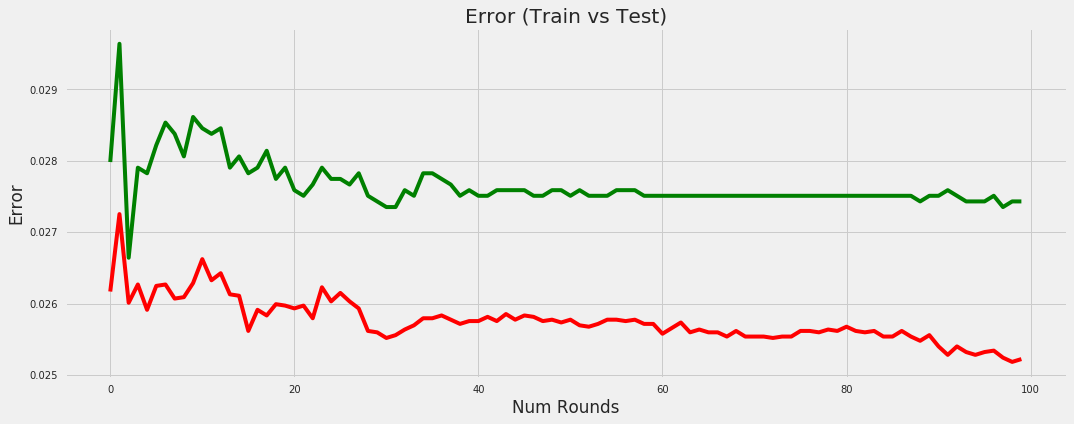

In [75]:
plt.figure(figsize = (16,6))
x_axis = list(range(100))
plt.plot(x_axis,cv_results['train-error-mean'],color = 'red',label = 'train_error')
plt.plot(x_axis,cv_results['test-error-mean'],color = 'green',label = 'test_error')
plt.title('Error (Train vs Test)')
plt.xlabel('Num Rounds')
plt.ylabel('Error')

**we see that test follows train but test has slightly higher error as compared to train, and this was expected.  
Now our main focus will be on to improve our model.  
Using:---   
Parameter Tunning of good performing models.  
Parameter Tunning of XGBoost  
Feature Selection.  
Feature Extraction using Dimensionality Reducion.  
Taking weighted average to make the final Prediction. ** 

#### Best Features Using XGBoost

In [76]:
##Model definition

model = xgb.XGBClassifier(max_depth=3,
                          learning_rate=0.1, 
                          n_estimators=500, silent=True,
                          objective='binary:logistic', 
                          booster='gbtree', n_jobs=1, nthread=None,
                          gamma=0, min_child_weight=1, 
                          max_delta_step=0, subsample=1, colsample_bytree=1,
                          colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                          scale_pos_weight=1, base_score=0.5)

model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

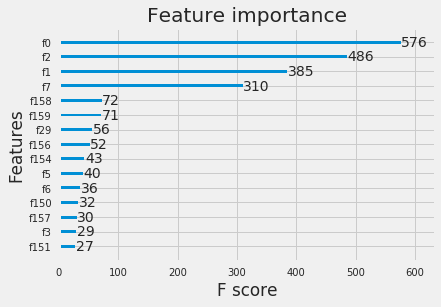

In [77]:
##Best features
xgb.plot_importance(model,max_num_features=15)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

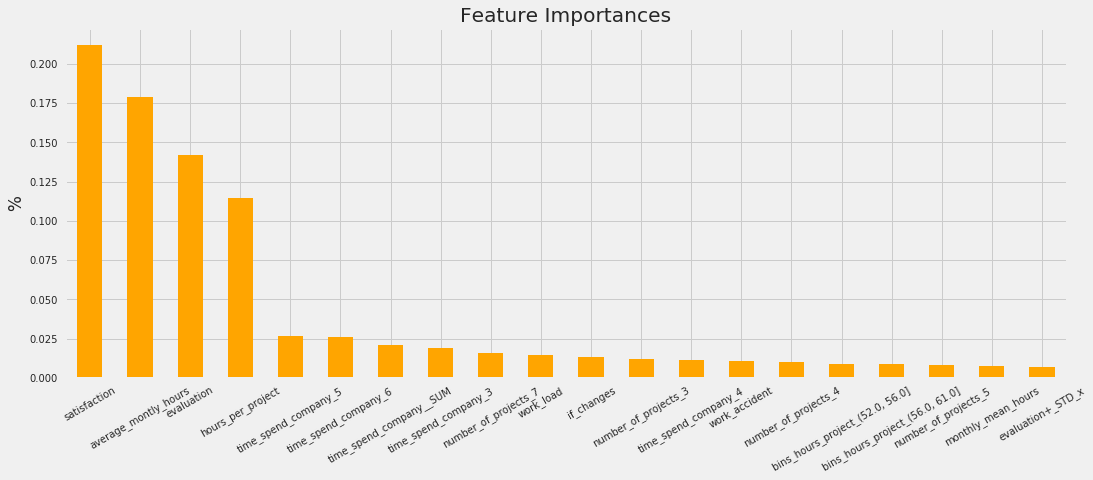

In [79]:
xgb_importances = pd.Series(model.feature_importances_,index = df.columns).sort_values(ascending = False)[:20]
xgb_importances.plot(kind = 'bar',figsize = (16,6),color = 'orange')
plt.title("Feature Importances")
plt.ylabel("%")
plt.xticks(rotation = 30)

In [80]:
##we have totol 198 featuers

##Lets's select best features given by xgboost upto a certain threshold
best_features = pd.Series(model.feature_importances_,index = df.columns).sort_values(ascending = False)
##selecting features which have importances greater then 0.000
best_features = best_features[best_features > 0.00]

In [81]:
##Training on best features
X_train_xbg_best = df[best_features.index].values
dmatrix_best_features = xgb.DMatrix(data = X_train_xbg_best,label = y_train)
cv_best_results = xgb.cv(params = params,dtrain = churn_matrix,nfold = 5,num_boost_round = 100,
                   metrics = 'error',as_pandas = True)

Text(0,0.5,'Error')

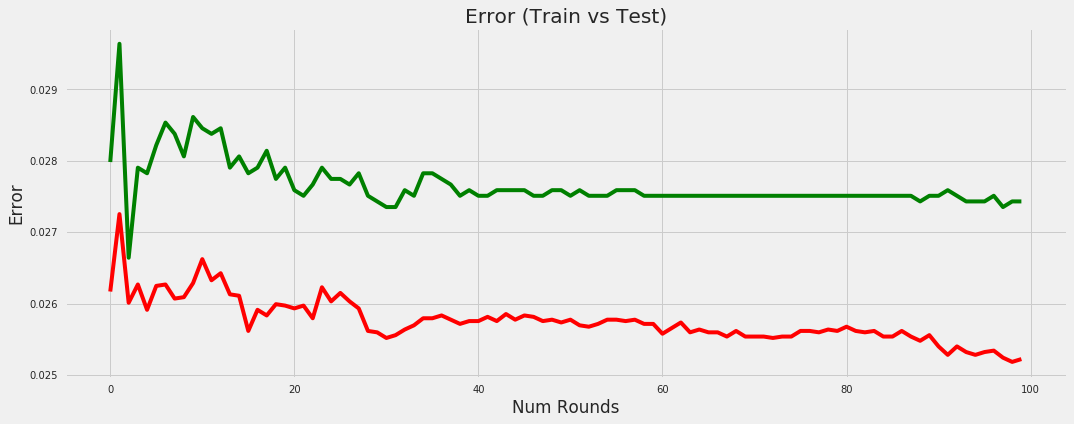

In [82]:
plt.figure(figsize = (16,6))
x_axis = list(range(100))
plt.plot(x_axis,cv_best_results['train-error-mean'],color = 'red',label = 'train_error')
plt.plot(x_axis,cv_best_results['test-error-mean'],color = 'green',label = 'test_error')
plt.title('Error (Train vs Test)')
plt.xlabel('Num Rounds')
plt.ylabel('Error')

Text(0.5,0,'Iteration')

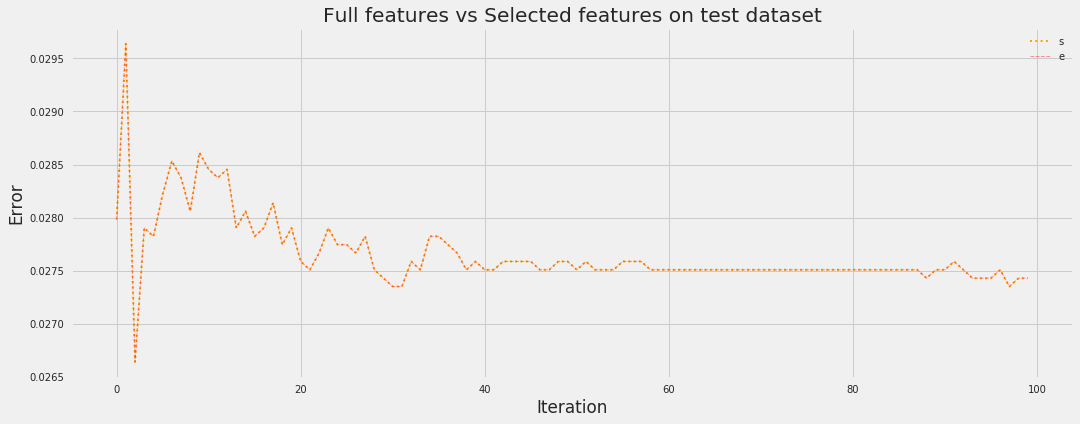

In [83]:
##Lets check if our result imroved or not
plt.figure(figsize = (16,6))
plt.plot(x_axis,cv_results['test-error-mean'],color = 'orange',linewidth = 2,linestyle = ':') ##for full feature
plt.legend('All_features')
plt.plot(x_axis,cv_best_results['test-error-mean'],color = 'red',linewidth = 1,linestyle = '--',alpha = 0.4) ##for full feature
plt.legend('selected_features')
plt.title('Full features vs Selected features on test dataset')
plt.ylabel("Error")
plt.xlabel("Iteration")

What we see can be really interesting :--  
Selecting best features didn't imporoved our model but it is able to preserve the information about the data as the two plots overlapped thus saving our computational expenses.  

### Feature Selection Using correlation:-  
**Hare we are going to remove the feautres having correlation more then 95%**  

In [84]:
##Lets try to remove all those features with correlation greater then 0.95.
corr_matrix = df.corr().abs()
upper = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

In [85]:
upper = upper.reset_index()
upper.head()

,level_0,level_1,0
0,number_of_projects_+MAX,hours_per_project&MIN,1.0
1,hours_per_project&MIN,salary_high,1.0
2,hours_per_project__MIN,salary_high,1.0
3,hours_per_project__MIN,number_of_projects_+MAX,1.0
4,department_management,dept_vul_2,1.0


In [86]:
##Subsetting
to_drop = upper.loc[(upper[0] > 0.95)]
##84 features are to be dropped
tp_drop = to_drop['level_0'].value_counts()

In [87]:
##Deleting the redundent Features

df.drop(tp_drop.index,axis = 1,inplace = True)

In [88]:
##getting new X_train
train_new = df.iloc[:,:].values

#Using XGBoost
##Training on best features
dmatrix_selected = xgb.DMatrix(data = train_new,label = target.values)
cv_selected = xgb.cv(params = params,dtrain = dmatrix_selected,nfold = 5,num_boost_round = 100,
                   metrics = 'error',as_pandas = True)
np.mean(cv_selected['test-error-mean'])

0.027817710000000013

Text(0.5,0,'Iteration')

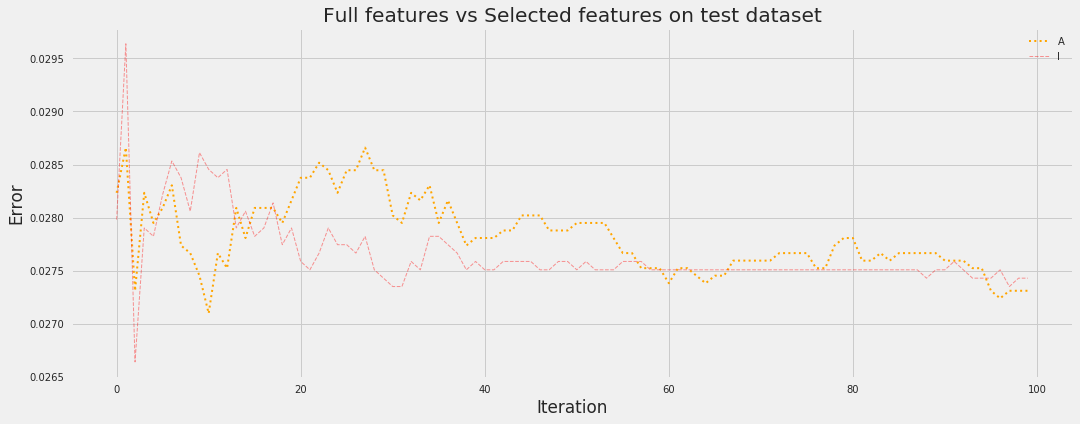

In [89]:
##Lets check if our result imroved or not
plt.figure(figsize = (16,6))
plt.plot(x_axis,cv_selected['test-error-mean'],color = 'orange',linewidth = 2,linestyle = ':') ##for full feature
plt.legend('selected features')
plt.plot(x_axis,cv_results['test-error-mean'],color = 'red',linewidth = 1,linestyle = '--',alpha = 0.4) ##for full feature
plt.legend('All_features')
plt.title('Full features vs Selected features on test dataset')
plt.ylabel("Error")
plt.xlabel("Iteration")

In [107]:
#del df['label']
df.head()

,satisfaction,evaluation,average_montly_hours,work_accident,promotion,work_load,if_changes,hours_per_project,monthly_min_hours,monthly_std_hours,monthly_mean_hours,time_spend_company_+_STD,number_of_projects_+_MAX,number_of_projects_+_MIN,evaluation_+_MEAN,evaluation_+_STD,satisfaction_+_MEAN,satisfaction_+_STD,hours_per_project_+_MEAN,hours_per_project_+_MAX,number_of_projects__MAX,number_of_projects__MIN,time_spend_company_-_MEAN,time_spend_company_-_STD,number_of_projects_-_MAX,number_of_projects_-_MIN,evaluation_-_MEAN,satisfaction_-_MEAN,satisfaction_-_STD,hours_per_project_-_MEAN,hours_per_project_-_STD,hours_per_project_-_MAX,hours_per_project_-_MIN,number_of_projects_+MIN,time_spend_company+_MEAN_x,time_spend_company+_STD_x,evaluation+_STD_x,satisfaction+_MEAN_x,satisfaction+_STD_x,hours_per_project+_MEAN_x,hours_per_project+_STD_x,hours_per_project+_MAX_x,hours_per_project+_MIN_x,dept_vul+_SUM_x,number_of_projects+_MAX_y,number_of_projects+_MIN_y,evaluation+_STD_y,time_spend_company+MEAN,time_spend_company+STD,number_of_projects+MAX,number_of_projects+MIN,evaluation+MEAN,evaluation+STD,satisfaction+MEAN,satisfaction+STD,hours_per_project+MEAN,hours_per_project+STD,hours_per_project+MAX,hours_per_project+MIN,dept_vul+SUM,work_load+SUM,time_spend_company&STD,number_of_projects&MAX,number_of_projects&MIN,hours_per_project&MAX,no_of_promotions,number_of_projects_2,number_of_projects_3,number_of_projects_4,number_of_projects_5,number_of_projects_6,number_of_projects_7,time_spend_company_2,time_spend_company_3,time_spend_company_4,time_spend_company_5,time_spend_company_6,time_spend_company_7,time_spend_company_8,time_spend_company_10,department_IT,department_RandD,department_accounting,department_hr,department_marketing,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium,dept_vul_0,dept_vul_1,dept_vul_2,"hours_bins_(95.999, 143.0]","hours_bins_(143.0, 160.0]","hours_bins_(160.0, 186.0]","hours_bins_(186.0, 214.0]","hours_bins_(214.0, 240.0]","hours_bins_(240.0, 261.0]","hours_bins_(261.0, 310.0]","bins_hours_project_(15.999, 34.0]","bins_hours_project_(34.0, 38.0]","bins_hours_project_(38.0, 43.0]","bins_hours_project_(43.0, 46.0]","bins_hours_project_(46.0, 49.0]","bins_hours_project_(49.0, 52.0]","bins_hours_project_(52.0, 56.0]","bins_hours_project_(56.0, 61.0]","bins_hours_project_(61.0, 65.0]","bins_hours_project_(65.0, 69.0]","bins_hours_project_(69.0, 75.0]","bins_hours_project_(75.0, 83.0]","bins_hours_project_(83.0, 155.0]"
0,0.38,0.53,157,0,0,0,1,78,96,49.560393,200.911353,1.512307,7,2,0.709717,0.171459,0.614447,0.250251,57.338647,148,7,2,3.483816,1.675255,6,2,0.702538,0.644906,0.23986,57.836457,21.952178,139,16,2,3.51,1.480479,0.173836,0.7085,0.19234,57.52,18.460704,122,28,100,6,2,0.169242,3.670748,0.924741,7,2,0.710414,0.177364,0.584017,0.25952,57.45632,19.63043,148,16,3022,2740,0.922753,7,2,155,100,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.72,0.87,223,0,0,1,1,44,96,49.560393,200.911353,1.512307,7,2,0.709717,0.171459,0.614447,0.250251,57.338647,148,7,2,3.483816,1.675255,6,2,0.702538,0.644906,0.23986,57.836457,21.952178,139,16,2,3.51,1.480479,0.173836,0.7085,0.19234,57.52,18.460704,122,28,100,6,2,0.169242,3.670748,0.924741,7,2,0.710414,0.177364,0.584017,0.25952,57.45632,19.63043,148,16,3022,2740,0.922753,7,2,155,100,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0.37,0.52,159,0,0,0,1,79,96,49.560393,200.911353,1.512307,7,2,0.709717,0.171459,0.614447,0.250251,57.338647,148,7,2,3.483816,1.675255,6,2,0.702538,0.644906,0.23986,57.836457,21.952178,139,16,2,3.51,1.480479,0.173836,0.7085,0.19234,57.52,18.460704,122,28,100,6,2,0.169242,3.670748,0.924741,7,2,0.710414,0.177364,0.584017,0.25952,57.45632,19.63043,148,16,3022,2740,0.922753,7,2,155,100,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.41,0.50,153,0,0,0,1,76,96,4

### Feature Selection using Recursive Feature Elimination  
This method eliminates worst performing features on a perticular model one after the another until the best subset of the features are known.  
It is computationaly expensive.  

In [108]:
from sklearn.feature_selection import RFECV
estimator = RandomForestClassifier(n_estimators = 100,max_depth = 3,random_state = 10,n_jobs = -1)
selector = RFECV(estimator,step = 1,cv = 3,scoring = scorer_p,n_jobs = -1)
selector.fit(df.iloc[:,:].values,target)

RFECV(cv=3,
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
   n_jobs=-1, scoring=make_scorer(precision_score), step=1, verbose=0)

Text(0.5,1,'Feature selection scores')

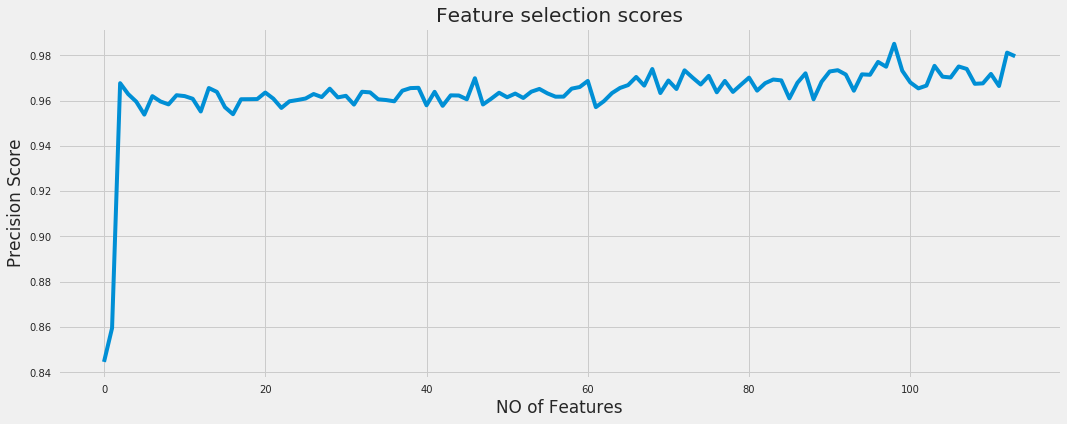

In [109]:
plt.figure(figsize = (16,6))
plt.plot(selector.grid_scores_)
plt.xlabel("NO of Features")
plt.ylabel("Precision Score")
plt.title("Feature selection scores")

In [110]:
## what we see is gradually score decreases as we eliminate the features.
selector.n_features_

99

In [111]:
##Define ranking
print(selector.ranking_[:20])
len(selector.ranking_)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


114

As we can see that features are ranked 1 to 4   
Let's select all those features whose rank is 1 and apply xgboost and see if score increases or not.

### Feature Extraction Using Dimensionality Reduction  
Dimensionality Reduction is not just a technique of reducing the number of dimensions,it helps us to represent the dataset in different feasture space by describing the data with minimal loss of information.  

We are going to use three techniques of dimensionality reduction:---   
1) PCA(Principle Component Analysis)  
2) TSNE(t-Distributed Stochastic Neighbor Embedding)  
3) UMAP(Uniform Manifold Approximation and Projection for Dimension Reduction)   


The main purpose is hare to indentify patterns to reduce the dimension of the dataset without loss of much of the information.

In [ ]:
##Installing umap
! pip install umap-learn

In [112]:
##Necessary imports
from umap.umap_ import UMAP
from sklearn.decomposition import PCA,FastICA
from sklearn.manifold import TSNE

In [113]:
##defining the number of components:--
n_components = 3
##Because I want to find clusters if any,,

umap = UMAP(n_components = n_components,random_state = 42)
pca  = PCA(n_components = n_components,random_state = 42)
ica  = FastICA(n_components = n_components,random_state = 42)
##TSNE is taking more time
#tsne = TSNE(n_components = n_components,random_state = 42)

## we are going to use newly created dataset outof selected features train_new.

In [114]:
#reduced_tsne = tsne.fit_transform(train_new)
pca  = pca.fit_transform(df)
ica  = ica.fit_transform(df)
umap = umap.fit_transform(df)

/home/ankit/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding 44 connected components using meta-embedding (experimental)
  n_components
/home/ankit/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [132]:
##Creating the dataframe
umap_df = pd.DataFrame({'umap_c1':umap[:,[0]].ravel(),'umap_c2':umap[:,[1]].ravel(),'umap_c3':umap[:,[2]].ravel()})
pca_df = pd.DataFrame({'pca_c1':pca[:,[0]].ravel(),'pca_c2':pca[:,[1]].ravel(),'pca_c3':pca[:,[2]].ravel()})
ica_df = pd.DataFrame({'ica_c1':ica[:,[0]].ravel(),'ica_c2':ica[:,[1]].ravel(),'ica_c3':ica[:,[2]].ravel()})

In [133]:
##Concatenating to the original df
df = pd.concat([df,umap_df,ica_df,pca_df],axis = 1)
df.head(3)

,satisfaction,evaluation,average_montly_hours,work_accident,promotion,work_load,if_changes,hours_per_project,monthly_min_hours,monthly_std_hours,monthly_mean_hours,time_spend_company_+_STD,number_of_projects_+_MAX,number_of_projects_+_MIN,evaluation_+_MEAN,evaluation_+_STD,satisfaction_+_MEAN,satisfaction_+_STD,hours_per_project_+_MEAN,hours_per_project_+_MAX,number_of_projects__MAX,number_of_projects__MIN,time_spend_company_-_MEAN,time_spend_company_-_STD,number_of_projects_-_MAX,number_of_projects_-_MIN,evaluation_-_MEAN,satisfaction_-_MEAN,satisfaction_-_STD,hours_per_project_-_MEAN,hours_per_project_-_STD,hours_per_project_-_MAX,hours_per_project_-_MIN,number_of_projects_+MIN,time_spend_company+_MEAN_x,time_spend_company+_STD_x,evaluation+_STD_x,satisfaction+_MEAN_x,satisfaction+_STD_x,hours_per_project+_MEAN_x,hours_per_project+_STD_x,hours_per_project+_MAX_x,hours_per_project+_MIN_x,dept_vul+_SUM_x,number_of_projects+_MAX_y,number_of_projects+_MIN_y,evaluation+_STD_y,time_spend_company+MEAN,time_spend_company+STD,number_of_projects+MAX,number_of_projects+MIN,evaluation+MEAN,evaluation+STD,satisfaction+MEAN,satisfaction+STD,hours_per_project+MEAN,hours_per_project+STD,hours_per_project+MAX,hours_per_project+MIN,dept_vul+SUM,work_load+SUM,time_spend_company&STD,number_of_projects&MAX,number_of_projects&MIN,hours_per_project&MAX,no_of_promotions,number_of_projects_2,number_of_projects_3,number_of_projects_4,number_of_projects_5,number_of_projects_6,number_of_projects_7,time_spend_company_2,time_spend_company_3,time_spend_company_4,time_spend_company_5,time_spend_company_6,time_spend_company_7,time_spend_company_8,time_spend_company_10,department_IT,department_RandD,department_accounting,department_hr,department_marketing,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium,dept_vul_0,dept_vul_1,dept_vul_2,"hours_bins_(95.999, 143.0]","hours_bins_(143.0, 160.0]","hours_bins_(160.0, 186.0]","hours_bins_(186.0, 214.0]","hours_bins_(214.0, 240.0]","hours_bins_(240.0, 261.0]","hours_bins_(261.0, 310.0]","bins_hours_project_(15.999, 34.0]","bins_hours_project_(34.0, 38.0]","bins_hours_project_(38.0, 43.0]","bins_hours_project_(43.0, 46.0]","bins_hours_project_(46.0, 49.0]","bins_hours_project_(49.0, 52.0]","bins_hours_project_(52.0, 56.0]","bins_hours_project_(56.0, 61.0]","bins_hours_project_(61.0, 65.0]","bins_hours_project_(65.0, 69.0]","bins_hours_project_(69.0, 75.0]","bins_hours_project_(75.0, 83.0]","bins_hours_project_(83.0, 155.0]",label,umap_c1,umap_c2,umap_c3,ica_c1,ica_c2,ica_c3,pca_c1,pca_c2,pca_c3
0,0.38,0.53,157,0,0,0,1,78,96,49.560393,200.911353,1.512307,7,2,0.709717,0.171459,0.614447,0.250251,57.338647,148,7,2,3.483816,1.675255,6,2,0.702538,0.644906,0.23986,57.836457,21.952178,139,16,2,3.51,1.480479,0.173836,0.7085,0.19234,57.52,18.460704,122,28,100,6,2,0.169242,3.670748,0.924741,7,2,0.710414,0.177364,0.584017,0.25952,57.45632,19.63043,148,16,3022,2740,0.922753,7,2,155,100,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,5.934506,9.889482,2.887302,0.006835,-0.006297,-0.010319,2001.375739,15.313684,-40.958800
1,0.72,0.87,223,0,0,1,1,44,96,49.560393,200.911353,1.512307,7,2,0.709717,0.171459,0.614447,0.250251,57.338647,148,7,2,3.483816,1.675255,6,2,0.702538,0.644906,0.23986,57.836457,21.952178,139,16,2,3.51,1.480479,0.173836,0.7085,0.19234,57.52,18.460704,122,28,100,6,2,0.169242,3.670748,0.924741,7,2,0.710414,0.177364,0.584017,0.25952,57.45632,19.63043,148,16,3022,2740,0.922753,7,2,155,100,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,-5.963895,1.003232,1.977141,-0.003362,-0.006252,-0.010326,2001.364774,15.402287,19.960814
2,0.37,0.52,159,0,0,0,1,79,96,49.560393,200.911353,1.512307,7,2,0.709717,0.171459,0.614447,0.250251,57.338647,148,7,2,3.483816,1.675255,6,2,0.702538,0.644906,0.23986,57.836457,21.952178,139,16,2,3.51,1.480479,0.173836,0.7085,0.19234,57.52,18.460704,122,28,10

In [134]:
##Plotting
from mpl_toolkits.mplot3d import Axes3D

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map
    Source: https://gist.github.com/jakevdp/91077b0cae40f8f8244a"""

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

cmap = discrete_cmap(2, base_cmap = plt.cm.RdYlBu)

df['label'] = target

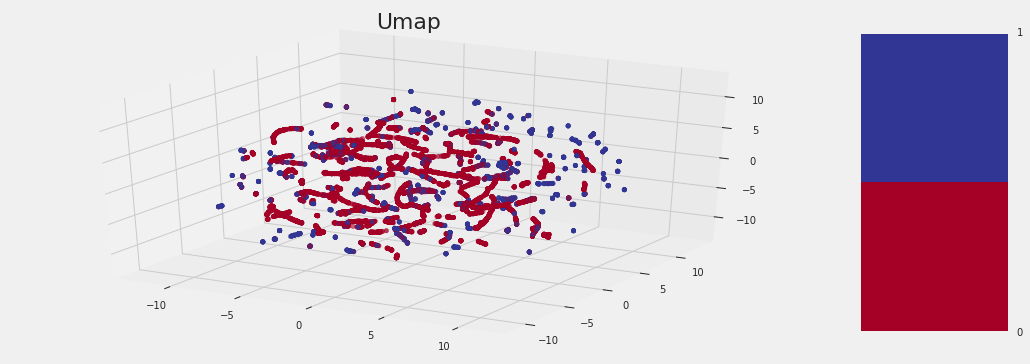

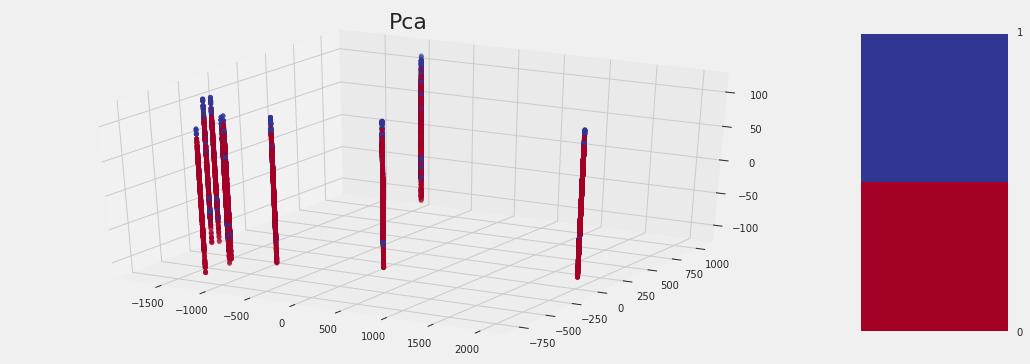

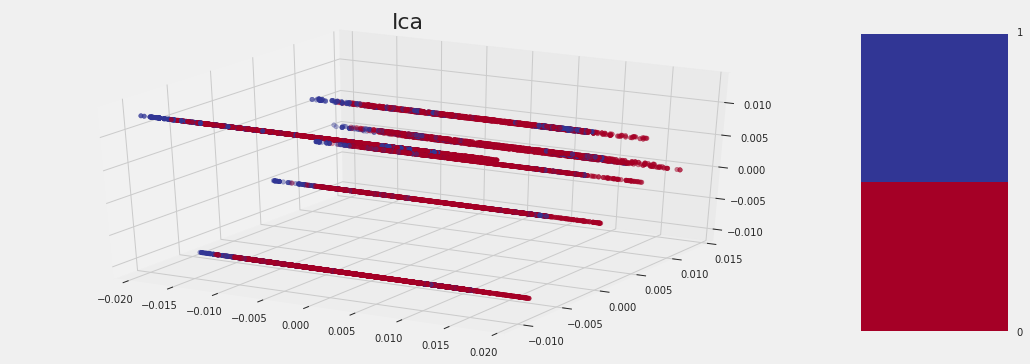

In [135]:
# Plot each method
for method, name in zip([umap, pca, ica], 
                        ['umap', 'pca', 'ica']):
    
    fig = plt.figure(figsize = (16, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    p = ax.scatter(df['%s_c1' % name], df['%s_c2'  % name], df['%s_c3'  % name], 
                   c = df['label'].astype(int), cmap = cmap)
    
    plt.title(f'{name.capitalize()}', size = 22)
    fig.colorbar(p, aspect = 2, ticks = [0,1])

ICA and PCA are doing exactly the same thing but on different dimensions this will be useful for generalization of the machine learning model.  
potting of UMAP is not clear though.  
we may try to increase the n_components for UMAP.  
One thing is worth noting in PCA and ICA blue dots are at the end of the lines(mostly).  

In [136]:
df.shape

(14097, 124)

In [137]:
df = df.astype('float32')

### Bayesian Optimization   

#### Parameter of XGBoost using Bayesian Optimization.  
As a breif primer it finds the value that minimizes an objective function by building a probability model based on past evaluation results of the model.  
Bayesian method differs from random or grid search models by the way that it uses past results to predict the next most likely parameters.  
##### concept :---    
**Limit Expansive evaluations of the objective function by choosing the next input values based on those that have done well in past.**  


In [138]:
##dataset splitting

del df['label']

train = df.iloc[:,:].values

X_train_reduced,X_test_reduced,y_train,y_test = train_test_split(train,y,test_size = .20,random_state = 42)

In [139]:
from hyperopt import STATUS_OK

n_folds = 10

matrix = xgb.DMatrix(X_train_reduced,y_train)

def objective(params,n_folds = n_folds):
    
    cv_selected = xgb.cv(params = params,dtrain = matrix,nfold = 5,num_boost_round = 100,
                       metrics = 'error',as_pandas = True)
    
    loss = np.mean(cv_selected['test-error-mean'])
    
    return {'loss':loss,'params':params,'status':STATUS_OK}



In [140]:
from hyperopt import hp

## discrete uniform distribution

space = {
    'boosting_type': hp.choice('boosting_type', 
                              [{'boosting_type': 'gbdt', 
                                'subsample': hp.uniform('gdbt_subsample', 0.5, 1),
                                'subsample_freq': hp.quniform('gbdt_subsample_freq', 1, 10, 1)}, 
                               {'boosting_type': 'dart', 
                                 'subsample': hp.uniform('dart_subsample', 0.5, 1),
                                 'subsample_freq': hp.quniform('dart_subsample_freq', 1, 10, 1),
                                 'drop_rate': hp.uniform('dart_drop_rate', 0.1, 0.5)},
                                {'boosting_type': 'goss',
                                 'subsample': 1.0,
                                 'subsample_freq': 0}]),
    'limit_max_depth': hp.choice('limit_max_depth', [True, False]),
    'max_depth': hp.choice('max_depth', np.arange(1, 14, dtype=int)),
    'num_leaves': hp.quniform('num_leaves', 3, 50, 1),
    'learning_rate': hp.loguniform('learning_rate', 
                                   np.log(0.025), 
                                   np.log(0.25)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 2000, 100000, 2000),
    'min_child_samples': hp.quniform('min_child_samples', 5, 80, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.5, 1.0),
    'objective':'binary:logistic'
}

In [141]:
##Optimization algorithms
from hyperopt import tpe
#{Tree Parzen Estimator}
tpe_algorithm = tpe.suggest

from hyperopt import Trials,fmin

bayes_trials = Trials()
best = fmin(fn = objective,space = space,algo = tpe.suggest,max_evals = 200,trials = bayes_trials)
best

{'boosting_type': 1,
 'colsample_by_tree': 0.9705787113662703,
 'dart_drop_rate': 0.10481709074419068,
 'dart_subsample': 0.8807619552902802,
 'dart_subsample_freq': 10.0,
 'learning_rate': 0.2488211061090212,
 'limit_max_depth': 1,
 'max_depth': 11,
 'min_child_samples': 10.0,
 'num_leaves': 18.0,
 'reg_alpha': 0.1236107627491404,
 'reg_lambda': 0.5912175686153809,
 'subsample_for_bin': 30000.0}

## Final Tunned XGBoost Model
This model uses the obtained parameters from the optimization.

In [153]:
final_model = xgb.XGBClassifier(boosting_type =  'dart',
             colsample_by_tree =  0.9705787113662703,
             dart_drop_rate =  0.10481709074419068,
             dart_subsample =  0.8807619552902802,
             dart_subsample_freq =  10.0,
             learning_rate =  0.2488211061090212,
             limit_max_depth =  True,
             max_depth =  11,
             min_child_samples = 10.0,
             num_leaves = 18.0,
             reg_alpha =  0.1236107627491404,
             reg_lambda =  0.5912175686153809,
             subsample_for_bin = 30000.0)

In [155]:
##Training
final_model.fit(X_train_reduced,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', boosting_type='dart',
       colsample_by_tree=0.9705787113662703, colsample_bylevel=1,
       colsample_bytree=1, dart_drop_rate=0.10481709074419068,
       dart_subsample=0.8807619552902802, dart_subsample_freq=10.0,
       gamma=0, learning_rate=0.2488211061090212, limit_max_depth=True,
       max_delta_step=0, max_depth=11, min_child_samples=10.0,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, num_leaves=18.0, objective='binary:logistic',
       random_state=0, reg_alpha=0.1236107627491404,
       reg_lambda=0.5912175686153809, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, subsample_for_bin=30000.0)

In [156]:
##Prediction: - -  
y_pred = final_model.predict(X_test_reduced)
y_pred

array([0, 0, 0, ..., 1, 0, 0])

[[2150   15]
 [   1  654]]


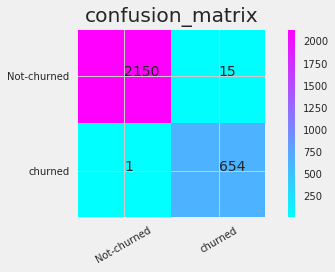

In [157]:
##Plotting the confusion matrix
plot_cm(y_pred,y_test,classes = ['Not-churned','churned'])

##It has exceptionally improved.

In [160]:
##f1_score
print(f1_score(y_pred,y_test)*100)

98.7915407855


In [161]:
##Roc_auc score
roc_auc_score(y_pred,y_test)

0.99577243798811765

In [162]:
##precision
precision_score(y_pred,y_test)

0.97757847533632292

In [163]:
##recall 
recall_score(y_pred,y_test)

0.99847328244274813

In [164]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred,y_test)

0.99432624113475176